# 04_models.ipynb

**Project:** ds-air-pollution-prediction  
**Author:** Iris Winkler, Carlos Duque, Johannes Gooth  
**Date:** April 29, 2024

---

## 📘 Introduction

In this notebook, we will focus on the **modeling phase** of the ds-air-pollution-prediction project. After completing data cleaning, preprocessing, and feature engineering in the previous notebook (`02_data_preparation.ipynb`), we are now ready to develop and evaluate predictive models for air pollution forecasting.

The primary goal is to build robust machine learning models that can accurately predict pollution levels based on meteorological data, pollutant concentrations, and other relevant environmental factors. We will employ a variety of machine learning models and pipelines to streamline the workflow and ensure reproducibility.

### Error Metric: Root Mean Squared Error (RMSE)

The **Root Mean Squared Error (RMSE)** is the chosen metric for evaluating model performance. This is aligned with the original competition on Zindi, which used RMSE to rank submissions. RMSE is widely used in regression tasks because it penalizes large errors more than smaller ones, making it an ideal metric for our pollution prediction task where accurate predictions are crucial.

For context, the **benchmark RMSE for our models** is **26.0997**, which was the winning score of the original competition. Our goal is to build models that can either meet or outperform this benchmark.

For more information on the original competition, you can refer to the [Zindi leaderboard](https://zindi.africa/competitions/urban-air-pollution-challenge/leaderboard).

### Key Steps:
1. **Model Selection and Training:** We will explore various models, including linear regression, decision trees, and ensemble methods. Pipelines from scikit-learn will be used to automate preprocessing and model training.
   
2. **Hyperparameter Tuning with GridSearch:** We will leverage GridSearchCV to optimize hyperparameters for each model, ensuring we extract the best possible performance.

3. **Model Evaluation:** Model performance will be evaluated using RMSE on both the training and test sets. This will allow us to assess how well each model generalizes to unseen data and compare results to the benchmark RMSE of 26.0997.

4. **MLFlow Integration:** We will track all experiments, hyperparameters, and results using MLFlow, enabling reproducibility and better comparison across different models and parameter settings.

5. **Pipeline Creation:** End-to-end pipelines will be built to handle data preprocessing, model training, and evaluation in one streamlined process, ensuring consistency and ease of use.

### Expected Outcome:
- **Optimized Models:** A set of well-tuned models that can predict air pollution levels with RMSE performance as close as possible to, or better than, the benchmark of 26.0997.
- **Reproducible Model Tracking:** Through MLFlow and pipelines, all steps of the modeling process will be tracked and reproducible, allowing for consistent improvement over time.

This notebook is the core of the predictive modeling process, where models will be constructed, evaluated, and refined in pursuit of achieving top-tier performance for air pollution prediction.

---

## ⚙️ Setting-Up the Working Enviroment

In [ ]:
# Avoid restarting Kernel 
%load_ext autoreload
%autoreload 2

import sys
# Setting the path
sys.path.append('../')

import os

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

from src.evaluation.evaluation_functions import *
from src.visualization.visualization_functions import *
from src.modeling.modeling_functions import *

from src.preprocessing.transformer_classes import (
    DropUvaerosolLayerHeightTransformer,
    ConvertDateTransformer,
    SortByDateTransformer,
    ExtractDateComponentsTransformer,
    DropDateTransformer
)

from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

import mlflow

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost as xgb
from sklearn.svm import SVR

---

## 📥 Loading the Data

In [2]:
# Load the data into a Pandas DataFrames
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')

In [3]:
# Convert y_train and y_test to series for modeling by selecting the 'pm2_5' column
y_train = y_train['pm2_5']
y_test = y_test['pm2_5']

---

## 🔄 Preprocessing Pipeline

In this section, we will implement a **preprocessing pipeline** to handle the necessary transformations on the **cathegorical** and **numerical features** in our dataset, ensuring they are properly prepared for the modeling phase.

### Custom Transformers

To maintain **modularity** and **reusability**, we have created several **custom transformer classes**, stored as separate modules within the `src/preprocessing/` directory. These transformers handle the specific preprocessing steps outlined in the data preparation phase, including:

- **`DropPlaceIDTransformer`**: Removes non-essential `ID` columns.
- **`DropUvaerosolLayerHeightTransformer`**: Drops irrelevant `uvaerosolLayerHeight` features.
- **`RemoveIQROutliersTransformer`**: Handles outliers using the IQR method.
- **`ConvertDateTransformer`**: Converts date columns into a standardized format.
- **`SortByDateTransformer`**: Sorts the data by date for consistent temporal analysis.
- **`ExtractDateComponentsTransformer`**: Extracts components like day, month, and year from date columns.
- **`DropDateTransformer`**: Drops the 'date' column after converting, sorting and extracting the components.

### Imputation and Scaling

For the more standard preprocessing tasks, such as **imputation** and **scaling**, we will use the following tools from `sklearn`:
- **`IterativeImputer`**: Used for imputing missing values in numerical features. This imputer models each feature as a function of the others, iteratively filling in missing values based on predictive modeling.
- **`StandardScaler`**: Standardizes numerical features by removing the mean and scaling to unit variance, ensuring all features are on the same scale for better performance with many machine learning algorithms.
- **`PCA`**: Principal Component Analysis is employed to reduce the dimensionality of the dataset while retaining most of the variance. This technique helps in improving model performance and reducing computational complexity by eliminating redundant features.

By combining **custom transformers** with powerful tools like **IterativeImputer**, **StandardScaler**, and **pca** from `sklearn`, our preprocessing pipeline is robust, modular, and ready for efficient model training. This approach ensures that our data is in optimal condition for achieving the best possible model performance.

### Defining Numerical and Categorical Features

In [4]:
# Make a list of all column names from X_train
columns_list = X_train.columns.tolist()

**Numerical Features**

In [5]:
# List of columns you want to drop
columns_to_drop = ['city', 'country', 'id', 'site_id']

# Dropping the specified columns using list comprehension
num_features = [col for col in columns_list if col not in columns_to_drop]

**Categorical Features**

In [6]:
# List of categorical columns
cat_features = [col for col in columns_list if col in ['city', 'country']]

### Defining the Preprocessing Pipeline

In [7]:
# Set the PCA components
fixed_n_components = 62

# Pipeline for numerical features
num_pipeline = Pipeline(steps=[
    ('drop_uvaerosol_layer_height', DropUvaerosolLayerHeightTransformer()),
    ('convert_date', ConvertDateTransformer(date_column='date', date_format='%Y-%m-%d')),
    ('extract_date_components', ExtractDateComponentsTransformer(date_column='date')),
    ('drop_date', DropDateTransformer()),
    ('imputer_num', IterativeImputer(max_iter=20)),
    ('std_scaler', StandardScaler()),
    ('pca', PCA(n_components=fixed_n_components))
])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

In [8]:
# Full preprocessing pipeline
preprocessing_pipeline = ColumnTransformer([
     ('num', num_pipeline, num_features),
     ('cat', cat_pipeline, cat_features)
 ])

In [50]:
# Plot the pipeline
preprocessing_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('drop_uvaerosol_layer_height',
                                                  DropUvaerosolLayerHeightTransformer(pattern=re.compile('uvaerosollayerheight', re.IGNORECASE))),
                                                 ('convert_date',
                                                  ConvertDateTransformer()),
                                                 ('extract_date_components',
                                                  ExtractDateComponentsTransformer()),
                                                 ('drop_date',
                                                  DropDateTransformer(pattern=re.compile('date', re.IG...
                                  'nitrogendioxide_stratospheric_no2_column_number_density',
                                  'nitrogendioxide_no2_slant_column_number_density',
                                  'nitrogendioxide_tropopause_pressure',
                                  'nitrogendioxide_absorbing_aerosol_index',
                                  'nitrogendioxide_cloud_fraction',
                                  'nitrogendioxide_sensor_altitude', ...]),
                                ('cat',
                                 Pipeline(steps=[('1hot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['city', 'country'])])

---

## 📏 Scoring Function

We have selected the Root Mean Squared Error (RMSE) as our metric for evaluating model performance, aligning with the original Zindi competition that also used RMSE to rank submissions. RMSE is a popular choice in regression tasks because it disproportionately penalizes larger errors more than smaller ones, making it particularly suitable for our pollution prediction task where precision is essential.

However, scikit-learn does not offer RMSE as a standard scoring option, which is necessary for implementing it within a grid search. Therefore, we need to create a custom scoring function to assess the performance of different grid search configurations

In [9]:
rmse_score = make_scorer(rmse_scorer, greater_is_better=False)

---

## 📈 Predictive Modeling
In this section, we leverage Scikit-Learn’s robust Pipelines to create a streamlined and reproducible workflow that seamlessly integrates data preprocessing with our machine learning algorithms. By incorporating Grid Search and Randomized Search, we systematically explore a comprehensive range of hyperparameter configurations with cross validation to identify the optimal settings for our models. Additionally, we utilize MLflow, an open-source platform for managing the end-to-end machine learning lifecycle, to meticulously track experiments, log model parameters and metrics, and facilitate model deployment. This combination not only enhances the efficiency of our modeling process but also ensures the robustness, transparency, and scalability of our predictive models. Through this structured approach, we aim to build reliable predictive models that effectively capture the underlying patterns in our data, while maintaining comprehensive records and facilitating seamless collaboration and deployment.

### MLFlow Settings

In [10]:
# Set the MLflow tracking URI to one level above the current directory inside the 'models' folder
mlflow.set_tracking_uri("../models/mlruns")

# Set the MLFlow experiment “ds-air-pollution-prediction”
mlflow.set_experiment("ds-air-pollution-prediction")

2024/10/02 09:48:29 INFO mlflow.tracking.fluent: Experiment with name 'ds-air-pollution-prediction' does not exist. Creating a new experiment.


<Experiment: artifact_location='/Users/hannes/Documents/coding/projects/neuefische/ds-zindi-air-pollution/notebooks/../models/mlruns/785635904273390698', creation_time=1727855309046, experiment_id='785635904273390698', last_update_time=1727855309046, lifecycle_stage='active', name='ds-air-pollution-prediction', tags={}>

### Linear Regression Model
Linear regression is one of the simplest and most widely used models for predicting a continuous target variable. It assumes a linear relationship between the independent variables (features) and the dependent variable (target), where the target can be modeled as a weighted sum of the features. The model aims to find the best-fit line by minimizing the sum of squared residuals, which are the differences between the observed and predicted values.

In this project, we implemented a linear regression model as a baseline to understand how well a simple linear relationship could capture the patterns in the data.

**GridSearchCV**

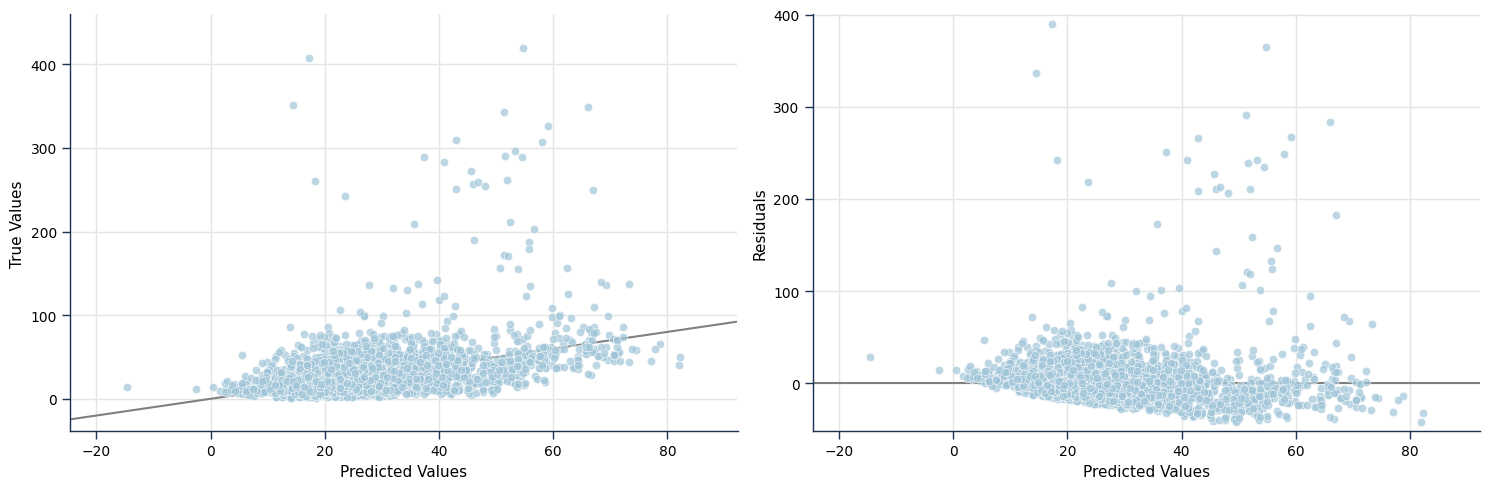

Best Parameters: {'model__fit_intercept': False}
Training RMSE: 21.99771002447544
Training R²: 0.1998684700291654
Training Adjusted R²: 0.1885180676467456


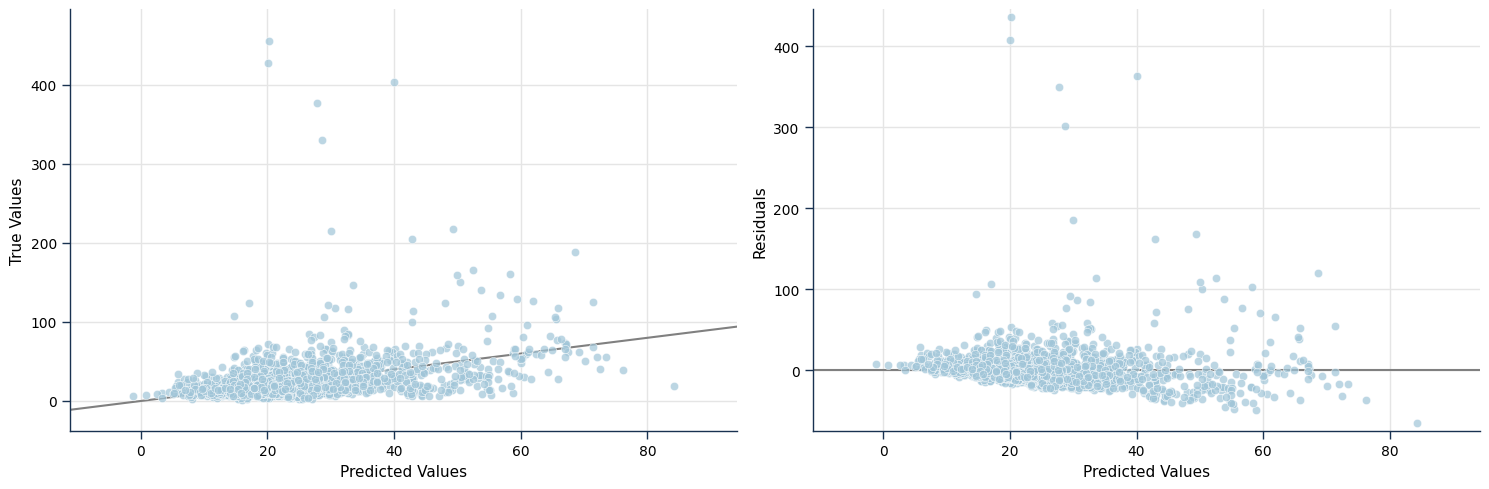

Test RMSE: 23.74112576368142
Test R²: 0.13519314321088838
Test Adjusted R²: 0.10602160534310867


(Pipeline(steps=[('preprocessing',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('drop_uvaerosol_layer_height',
                                                                    DropUvaerosolLayerHeightTransformer(pattern=re.compile('uvaerosollayerheight', re.IGNORECASE))),
                                                                   ('convert_date',
                                                                    ConvertDateTransformer()),
                                                                   ('extract_date_components',
                                                                    ExtractDateComponentsTransformer()),
                                                                   ('drop_date',
                                                                    DropDateTransforme...
                                                    'nitrogendioxide_stratospheric_no2_column

In [12]:
# Define the model
lr_model = LinearRegression()

# Define the hyperparameter grid for Linear Regression
lr_param_grid = {
    'model__fit_intercept': [True, False],  # Whether to fit the intercept
}

# Call training and evaluation function with GridSearchCV
train_and_evaluate_model(lr_model, lr_param_grid, preprocessing_pipeline, search_type='grid', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, scoring=rmse_score)

**RandomizedSearchCV**

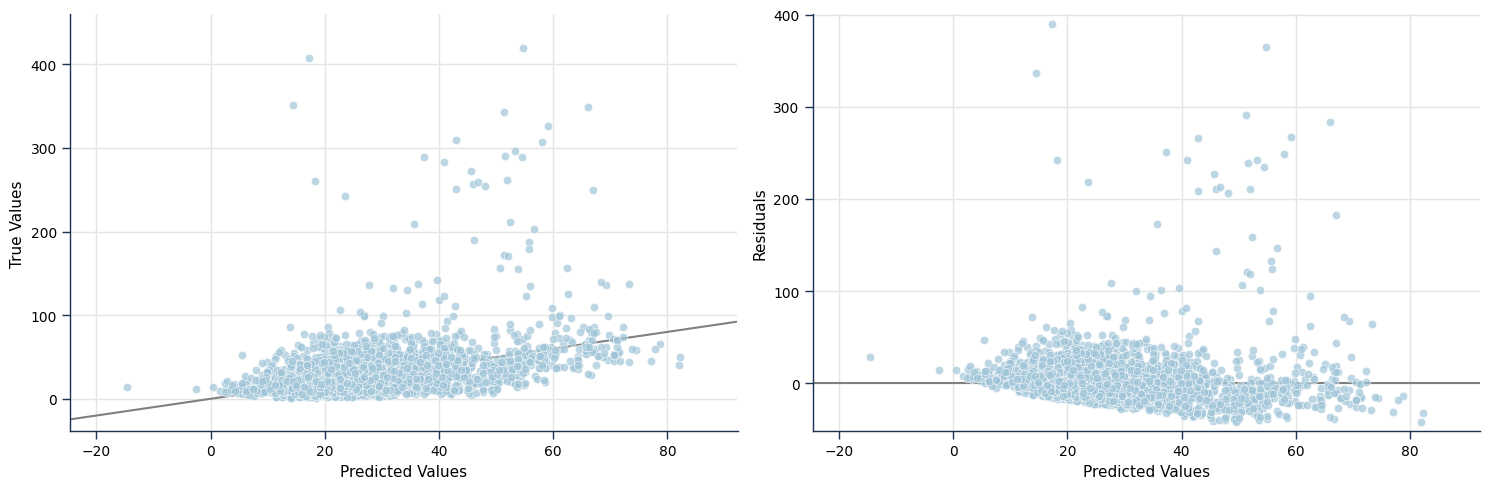

Best Parameters: {'model__fit_intercept': False}
Training RMSE: 21.99771002447544
Training R²: 0.1998684700291654
Training Adjusted R²: 0.1885180676467456


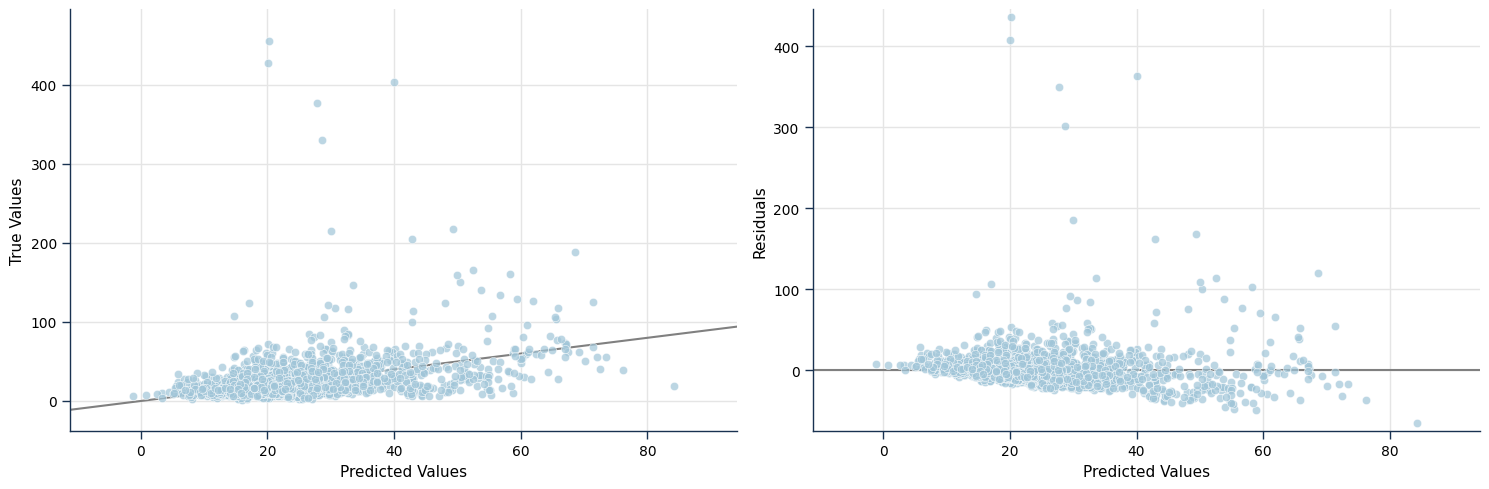

Test RMSE: 23.74112576368142
Test R²: 0.13519314321088838
Test Adjusted R²: 0.10602160534310867


(Pipeline(steps=[('preprocessing',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('drop_uvaerosol_layer_height',
                                                                    DropUvaerosolLayerHeightTransformer(pattern=re.compile('uvaerosollayerheight', re.IGNORECASE))),
                                                                   ('convert_date',
                                                                    ConvertDateTransformer()),
                                                                   ('extract_date_components',
                                                                    ExtractDateComponentsTransformer()),
                                                                   ('drop_date',
                                                                    DropDateTransforme...
                                                    'nitrogendioxide_stratospheric_no2_column

In [13]:
# Call training and evaluation function with RandomSearchCV
train_and_evaluate_model(lr_model, lr_param_grid, preprocessing_pipeline, search_type='random', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, scoring=rmse_score)

### Ridge Regression Model
Ridge regression is an extension of linear regression that introduces a regularization parameter (L2 penalty) to the loss function. This penalty term adds the squared magnitude of the coefficients as a constraint, which helps prevent overfitting by shrinking the coefficients towards zero but not exactly zero. Ridge regression is particularly useful when dealing with multicollinearity, as it stabilizes the estimation by adding bias but reducing variance.

In this project, we implemented a ridge regression model to understand how L2 regularization affects the model’s ability to capture patterns in the data and to improve its generalization performance over simple linear regression.

**GridSearchCV**

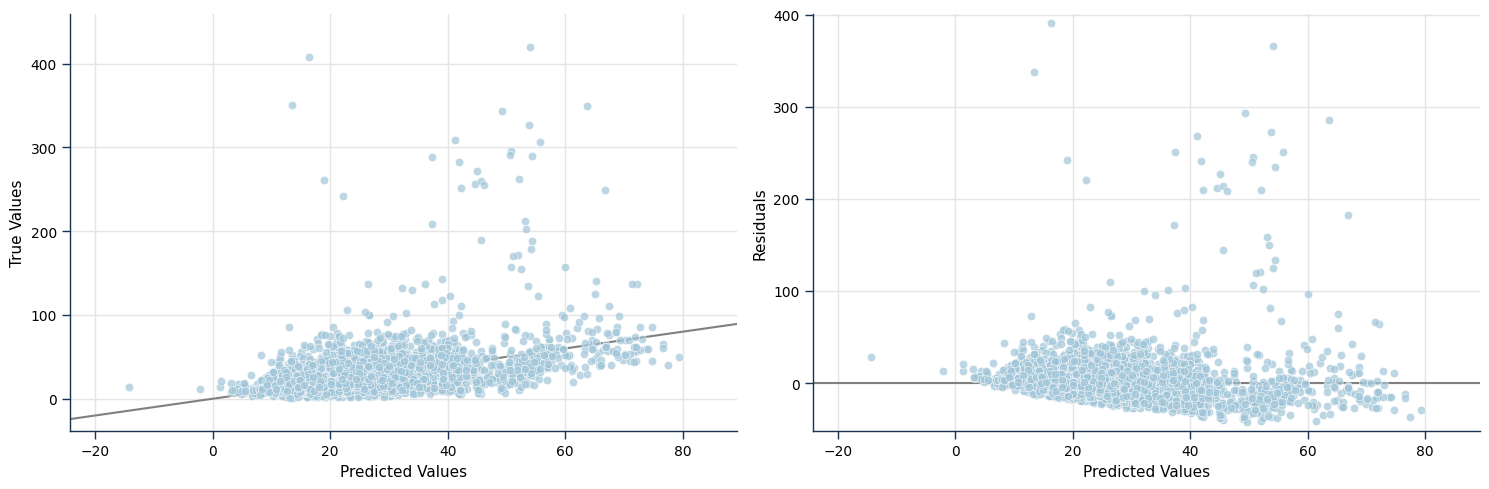

Best Parameters: {'model__alpha': 0.1, 'model__fit_intercept': False}
Training RMSE: 22.03631591559939
Training R²: 0.19705755049029627
Training Adjusted R²: 0.18566727332899868


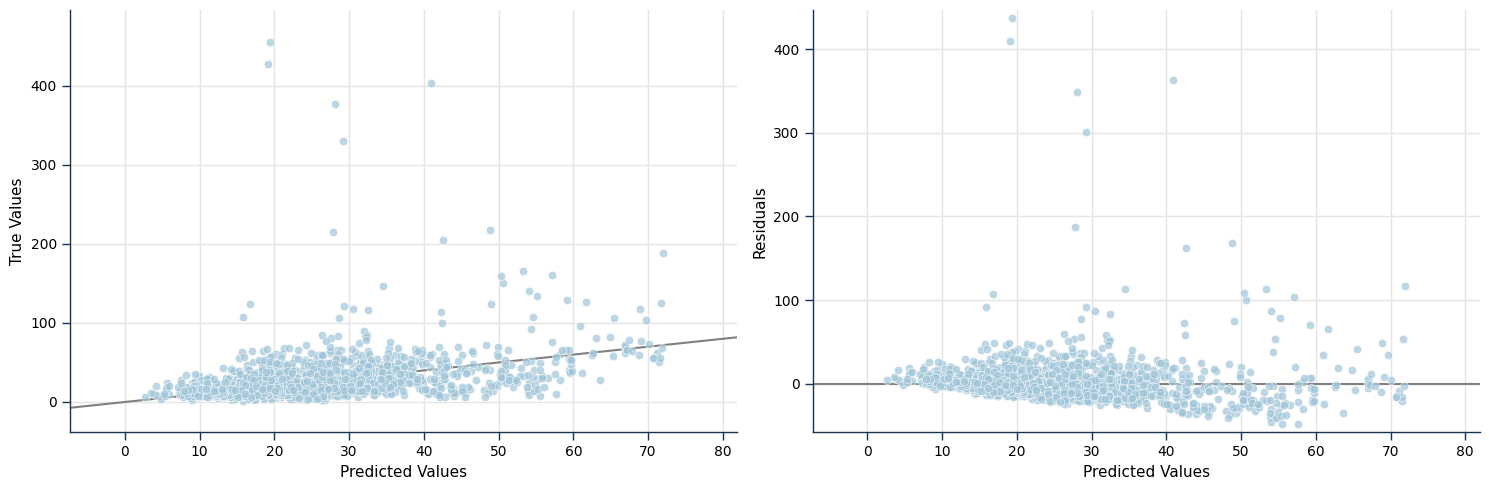

Test RMSE: 23.653354864465797
Test R²: 0.14157570199334757
Test Adjusted R²: 0.11261945966092846


(Pipeline(steps=[('preprocessing',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('drop_uvaerosol_layer_height',
                                                                    DropUvaerosolLayerHeightTransformer(pattern=re.compile('uvaerosollayerheight', re.IGNORECASE))),
                                                                   ('convert_date',
                                                                    ConvertDateTransformer()),
                                                                   ('extract_date_components',
                                                                    ExtractDateComponentsTransformer()),
                                                                   ('drop_date',
                                                                    DropDateTransforme...
                                                    'nitrogendioxide_stratospheric_no2_column

In [14]:
# Define the model
ridge_model = Ridge()

# Define the hyperparameter grid for Ridge Regression
ridge_param_grid = {
    'model__alpha': [0.01, 0.1, 1, 10.0, 100.0],  # Regularization strength
    'model__fit_intercept': [True, False],  # Whether to fit the intercept
}

# Call training and evaluation function with GridSearchCV
train_and_evaluate_model(ridge_model, ridge_param_grid, preprocessing_pipeline, search_type='grid', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

**RandomizedSearchCV**

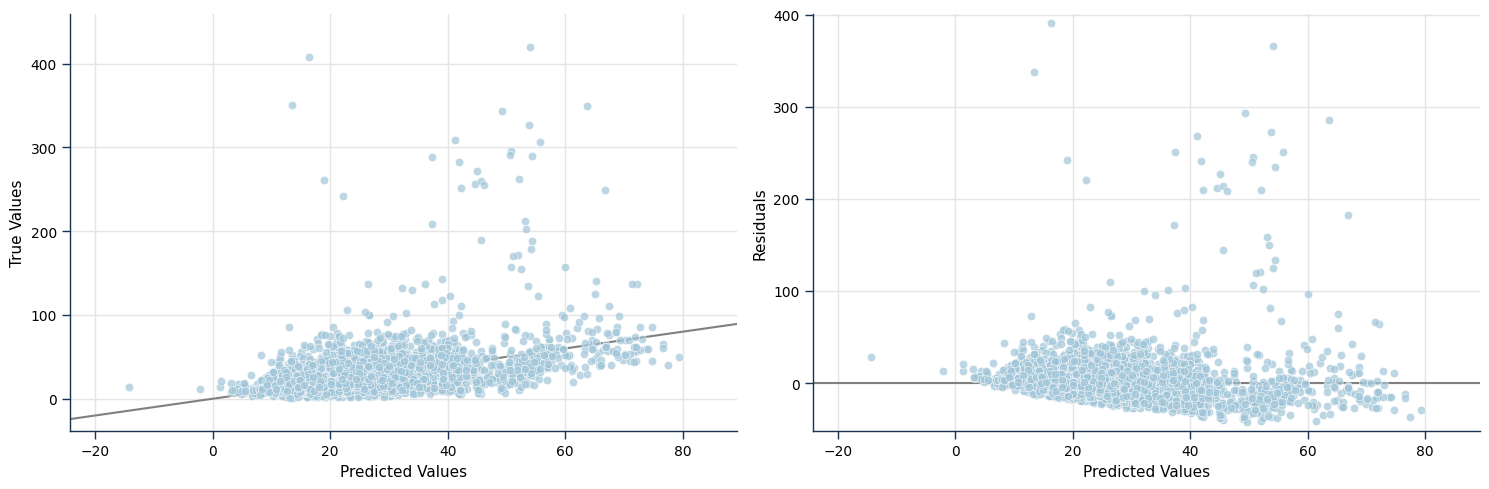

Best Parameters: {'model__fit_intercept': False, 'model__alpha': 0.1}
Training RMSE: 22.03631591559939
Training R²: 0.19705755049029627
Training Adjusted R²: 0.18566727332899868


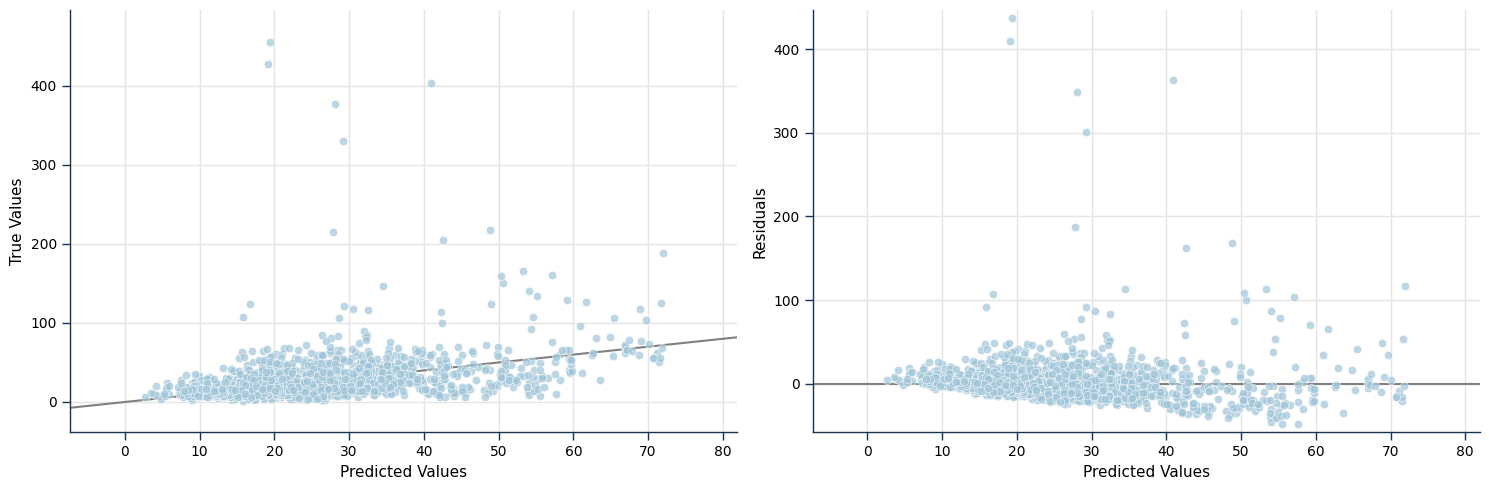

Test RMSE: 23.653354864465797
Test R²: 0.14157570199334757
Test Adjusted R²: 0.11261945966092846


(Pipeline(steps=[('preprocessing',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('drop_uvaerosol_layer_height',
                                                                    DropUvaerosolLayerHeightTransformer(pattern=re.compile('uvaerosollayerheight', re.IGNORECASE))),
                                                                   ('convert_date',
                                                                    ConvertDateTransformer()),
                                                                   ('extract_date_components',
                                                                    ExtractDateComponentsTransformer()),
                                                                   ('drop_date',
                                                                    DropDateTransforme...
                                                    'nitrogendioxide_stratospheric_no2_column

In [15]:
# Call training and evaluation function with RandomSearchCV
train_and_evaluate_model(ridge_model, ridge_param_grid, preprocessing_pipeline, search_type='random', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

### Lasso Regression Model
Lasso regression, short for Least Absolute Shrinkage and Selection Operator, is another regularized version of linear regression that incorporates an L1 penalty into the loss function. This penalty adds the absolute value of the coefficients, promoting sparsity by driving some coefficients exactly to zero. As a result, lasso regression performs both variable selection and regularization, which can simplify models and enhance interpretability.

In this project, we implemented a lasso regression model to explore how L1 regularization can improve model performance by selecting the most significant features and reducing overfitting.

**GridSearchCV**

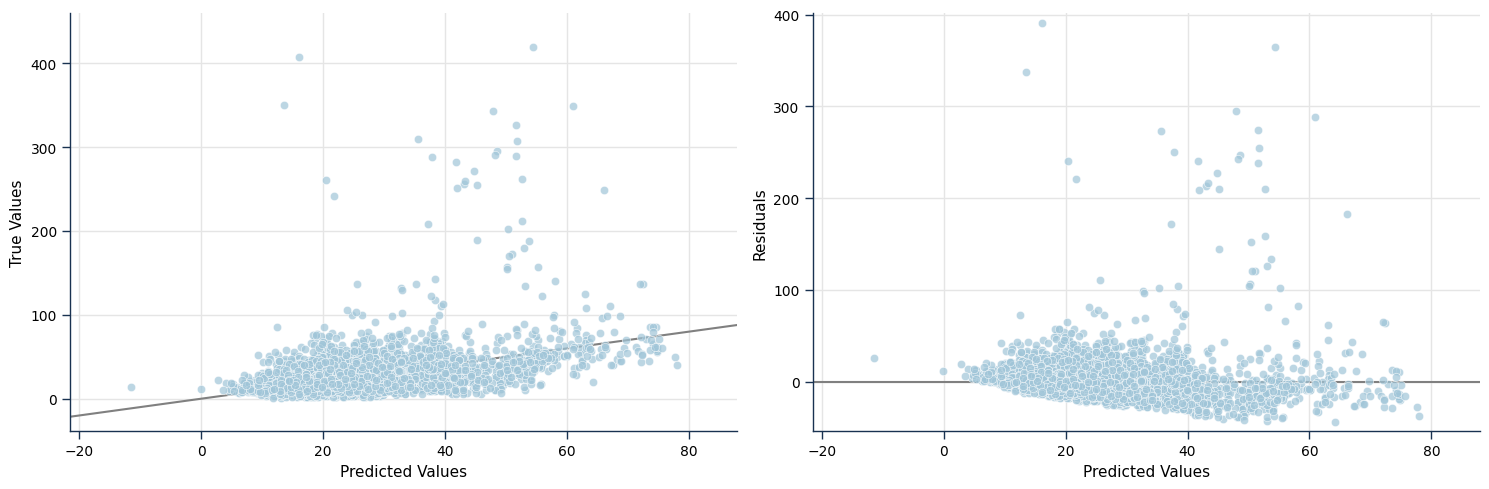

Best Parameters: {'model__alpha': 0.01, 'model__fit_intercept': False}
Training RMSE: 22.110477875366062
Training R²: 0.19164394249921013
Training Adjusted R²: 0.1801768696777768


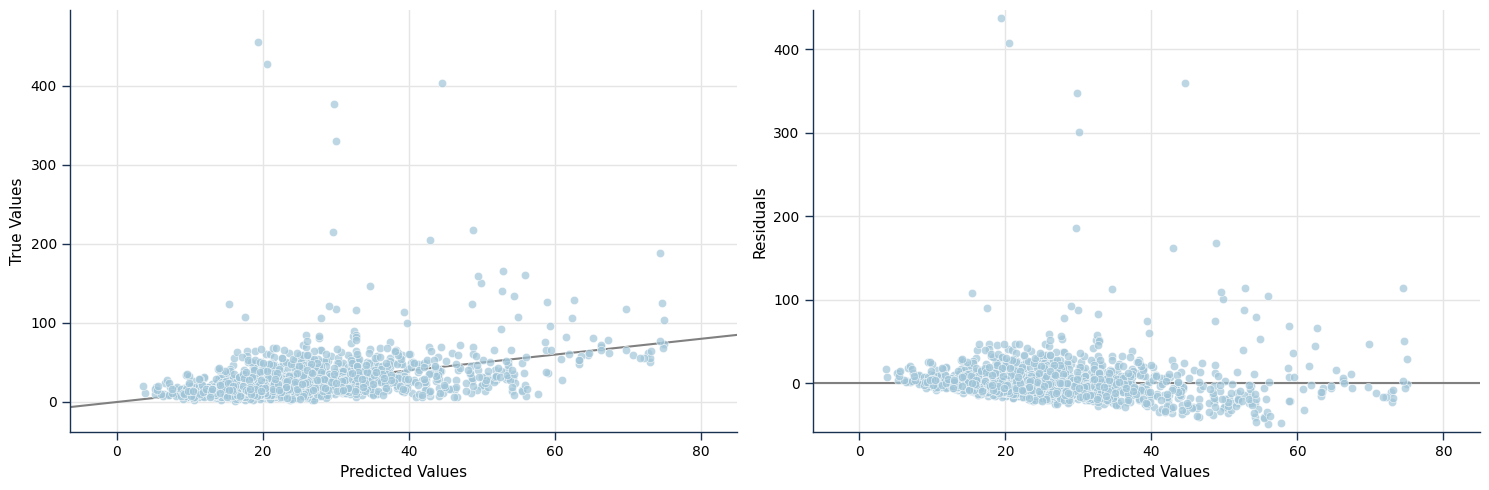

Test RMSE: 23.569441958712705
Test R²: 0.14765560949967527
Test Adjusted R²: 0.11890445371422453


(Pipeline(steps=[('preprocessing',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('drop_uvaerosol_layer_height',
                                                                    DropUvaerosolLayerHeightTransformer(pattern=re.compile('uvaerosollayerheight', re.IGNORECASE))),
                                                                   ('convert_date',
                                                                    ConvertDateTransformer()),
                                                                   ('extract_date_components',
                                                                    ExtractDateComponentsTransformer()),
                                                                   ('drop_date',
                                                                    DropDateTransforme...
                                                    'nitrogendioxide_stratospheric_no2_column

In [16]:
# Define the model
lasso_model = Lasso()

# Define the hyperparameter grid for Lasso Regression
lasso_param_grid = {
    'model__alpha': [0.01, 0.1, 1, 10.0, 100.0],  # Regularization strength
    'model__fit_intercept': [True, False],  # Whether to fit the intercept
}

# Call training and evaluation function with GridSearchCV
train_and_evaluate_model(lasso_model, lasso_param_grid, preprocessing_pipeline, search_type='grid', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

**RandomizedSearchCV**

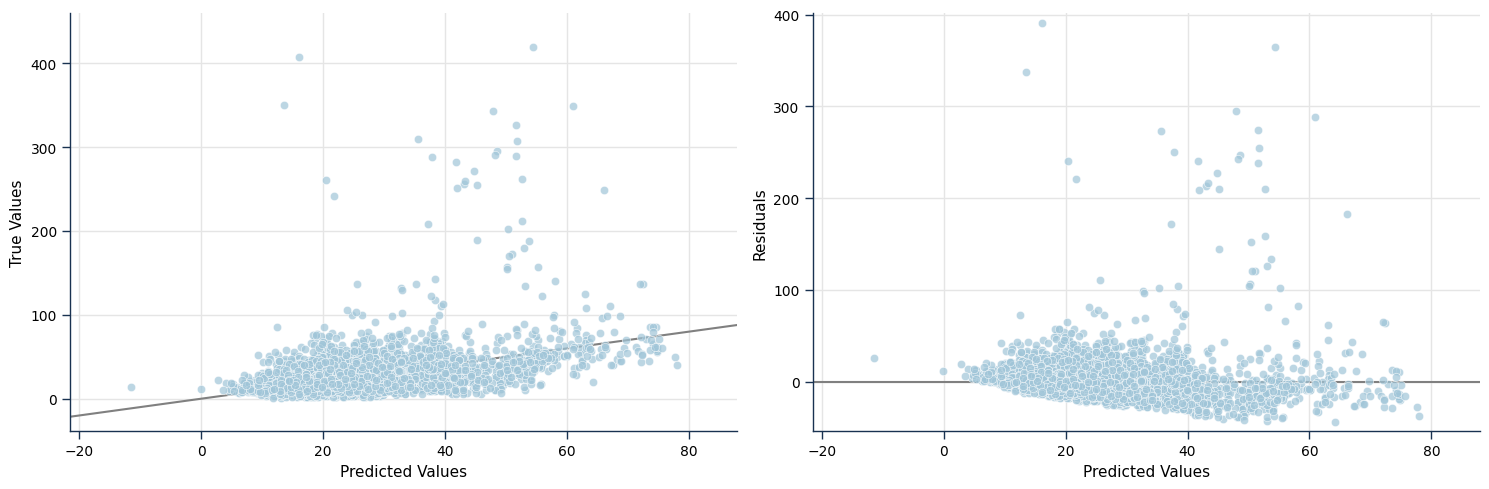

Best Parameters: {'model__fit_intercept': False, 'model__alpha': 0.01}
Training RMSE: 22.110477875366062
Training R²: 0.19164394249921013
Training Adjusted R²: 0.1801768696777768


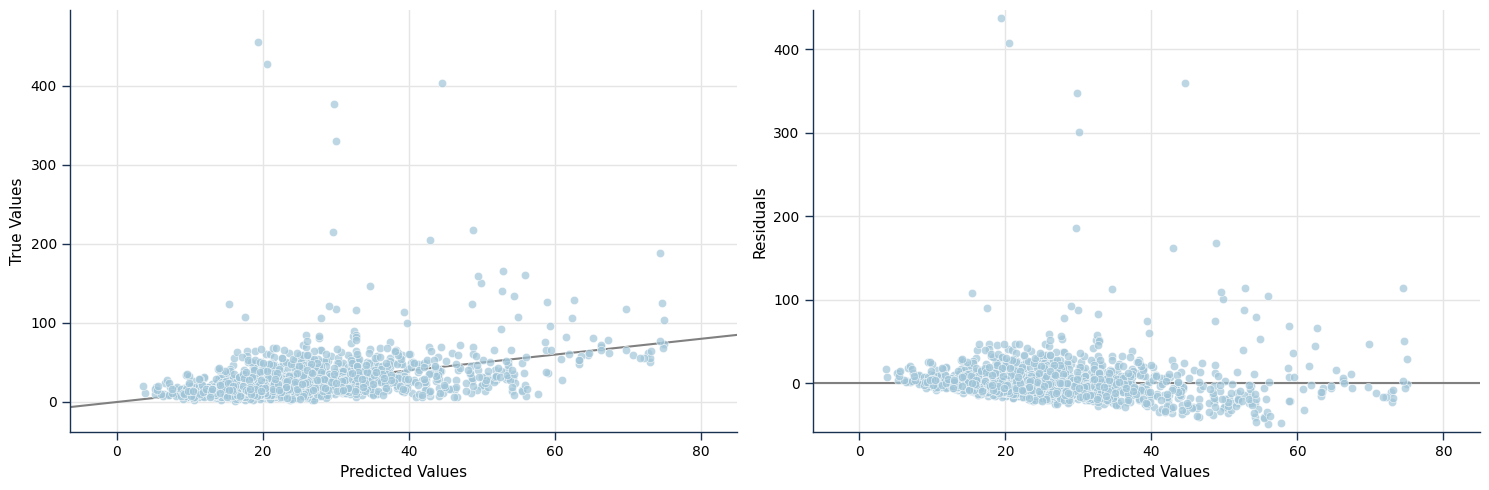

Test RMSE: 23.569441958712705
Test R²: 0.14765560949967527
Test Adjusted R²: 0.11890445371422453


(Pipeline(steps=[('preprocessing',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('drop_uvaerosol_layer_height',
                                                                    DropUvaerosolLayerHeightTransformer(pattern=re.compile('uvaerosollayerheight', re.IGNORECASE))),
                                                                   ('convert_date',
                                                                    ConvertDateTransformer()),
                                                                   ('extract_date_components',
                                                                    ExtractDateComponentsTransformer()),
                                                                   ('drop_date',
                                                                    DropDateTransforme...
                                                    'nitrogendioxide_stratospheric_no2_column

In [17]:
# Call training and evaluation function with RandomSearchCV
train_and_evaluate_model(lasso_model, lasso_param_grid, preprocessing_pipeline, search_type='random', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

### Elastic Net Regression Model
Elastic Net regression combines both L1 and L2 regularization penalties in its loss function. This hybrid approach addresses the limitations of ridge and lasso regression by balancing the benefits of both. Elastic Net is particularly effective when dealing with datasets that have highly correlated predictors, as it can select groups of correlated variables together.

In this project, we implemented an elastic net regression model to investigate how the combination of L1 and L2 regularization can enhance the model’s predictive performance and handle multicollinearity in the data.

**GridSearchCV**

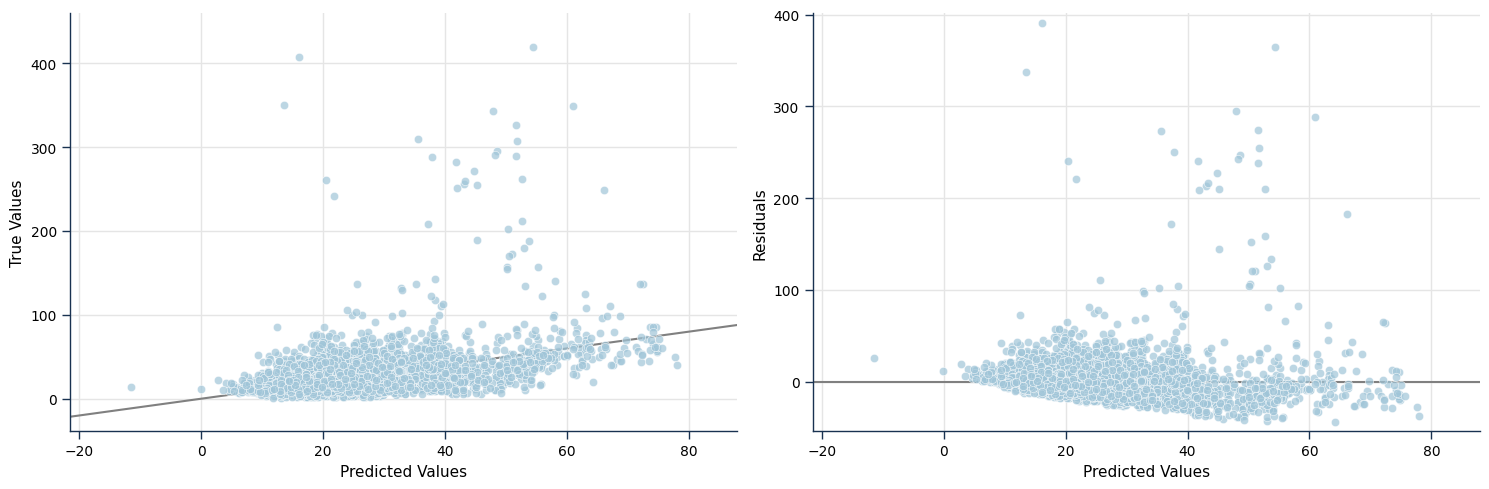

Best Parameters: {'model__alpha': 0.01, 'model__fit_intercept': False, 'model__l1_ratio': 1.0}
Training RMSE: 22.110477875366062
Training R²: 0.19164394249921013
Training Adjusted R²: 0.1801768696777768


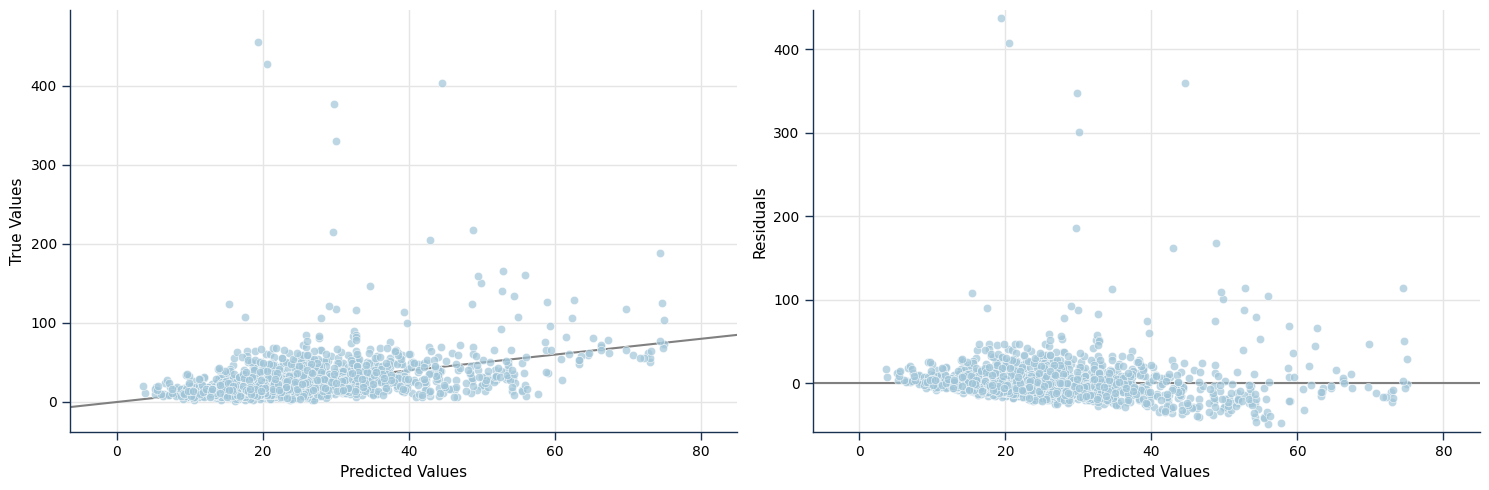

Test RMSE: 23.569441958712705
Test R²: 0.14765560949967527
Test Adjusted R²: 0.11890445371422453


(Pipeline(steps=[('preprocessing',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('drop_uvaerosol_layer_height',
                                                                    DropUvaerosolLayerHeightTransformer(pattern=re.compile('uvaerosollayerheight', re.IGNORECASE))),
                                                                   ('convert_date',
                                                                    ConvertDateTransformer()),
                                                                   ('extract_date_components',
                                                                    ExtractDateComponentsTransformer()),
                                                                   ('drop_date',
                                                                    DropDateTransforme...
                                                    'nitrogendioxide_no2_slant_column_number_

In [18]:
# Define the model
elastic_net_model = ElasticNet()

# Define the hyperparameter grid for Elastic Net
elastic_net_param_grid = {
    'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],  # Regularization strength
    'model__l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0],  # Mix between L1 (Lasso) and L2 (Ridge)
    'model__fit_intercept': [True, False],  # Whether to fit the intercept
}

# Call training and evaluation function with GridSearchCV
train_and_evaluate_model(elastic_net_model, elastic_net_param_grid, preprocessing_pipeline, search_type='grid', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

**RandomizedSearchCV**

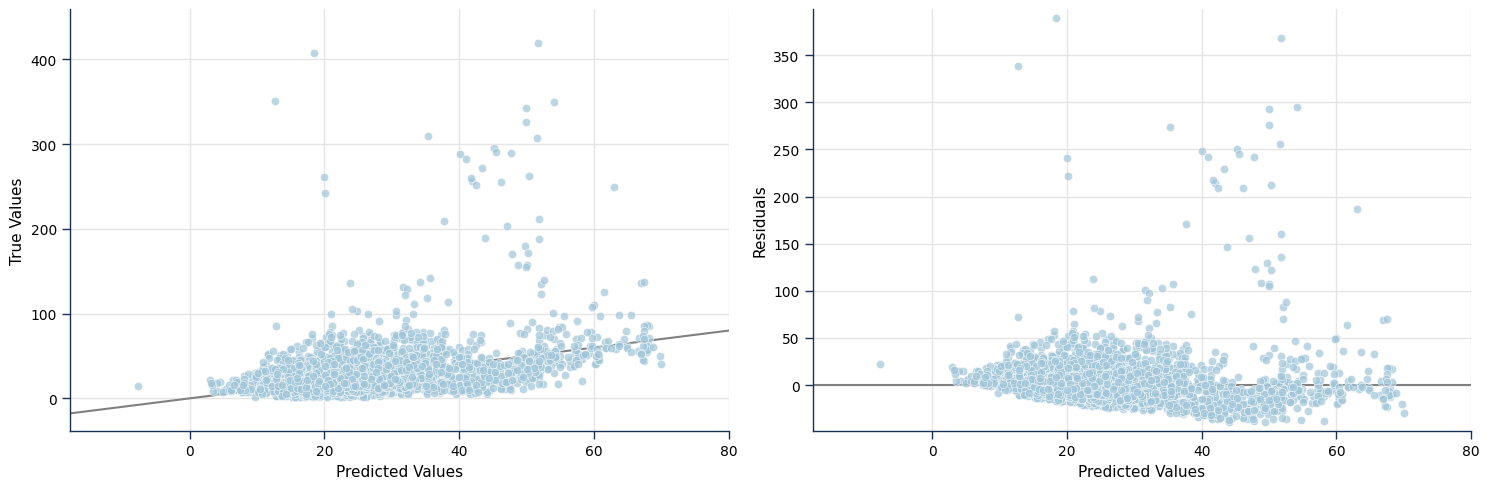

Best Parameters: {'model__l1_ratio': 1.0, 'model__fit_intercept': False, 'model__alpha': 0.1}
Training RMSE: 22.28388565940549
Training R²: 0.17891469117005265
Training Adjusted R²: 0.16726704538129955


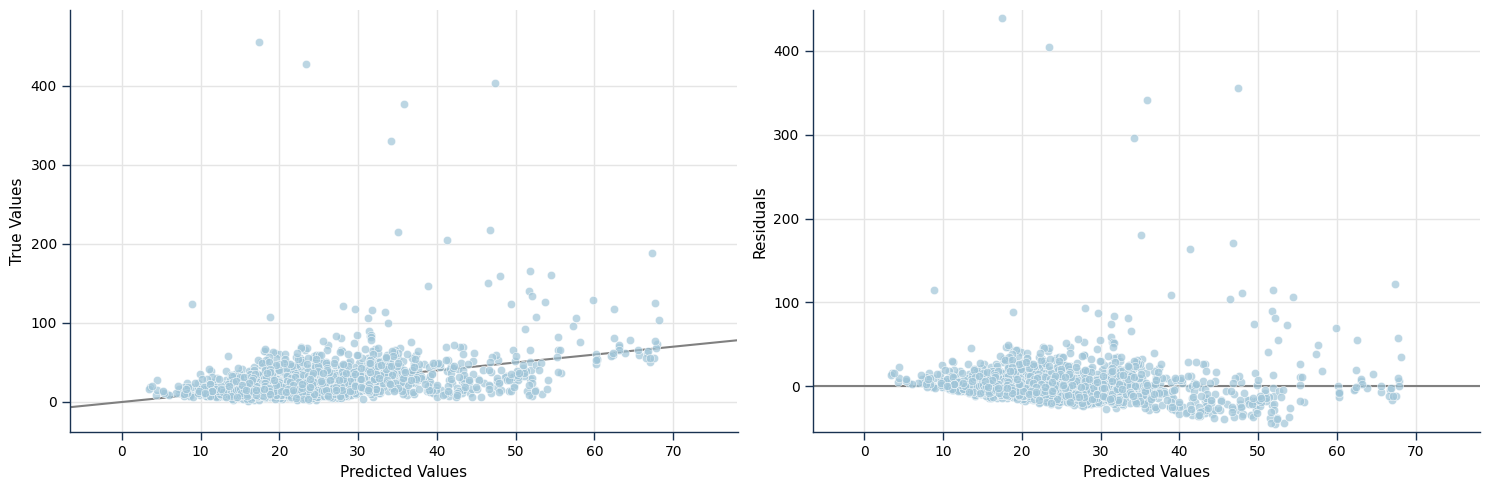

Test RMSE: 23.592850959657856
Test R²: 0.1459616840318556
Test Adjusted R²: 0.11715338900133332


(Pipeline(steps=[('preprocessing',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('drop_uvaerosol_layer_height',
                                                                    DropUvaerosolLayerHeightTransformer(pattern=re.compile('uvaerosollayerheight', re.IGNORECASE))),
                                                                   ('convert_date',
                                                                    ConvertDateTransformer()),
                                                                   ('extract_date_components',
                                                                    ExtractDateComponentsTransformer()),
                                                                   ('drop_date',
                                                                    DropDateTransforme...
                                                    'nitrogendioxide_no2_slant_column_number_

In [19]:
# Call training and evaluation function with RandomSearchCV
train_and_evaluate_model(elastic_net_model, elastic_net_param_grid, preprocessing_pipeline, search_type='random', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

### K-Nearest Neighbors (KNN) Model
The K-Nearest Neighbors (KNN) algorithm is a non-parametric, instance-based learning method used for both classification and regression tasks. In KNN regression, the prediction for a new data point is calculated as the average of the target values of its k nearest neighbors in the feature space. The algorithm relies on the assumption that similar input features correspond to similar output values.

In this project, we implemented a KNN regression model to understand how local patterns in the data can be captured by considering the target values of nearby data points.

**GridSearchCV**

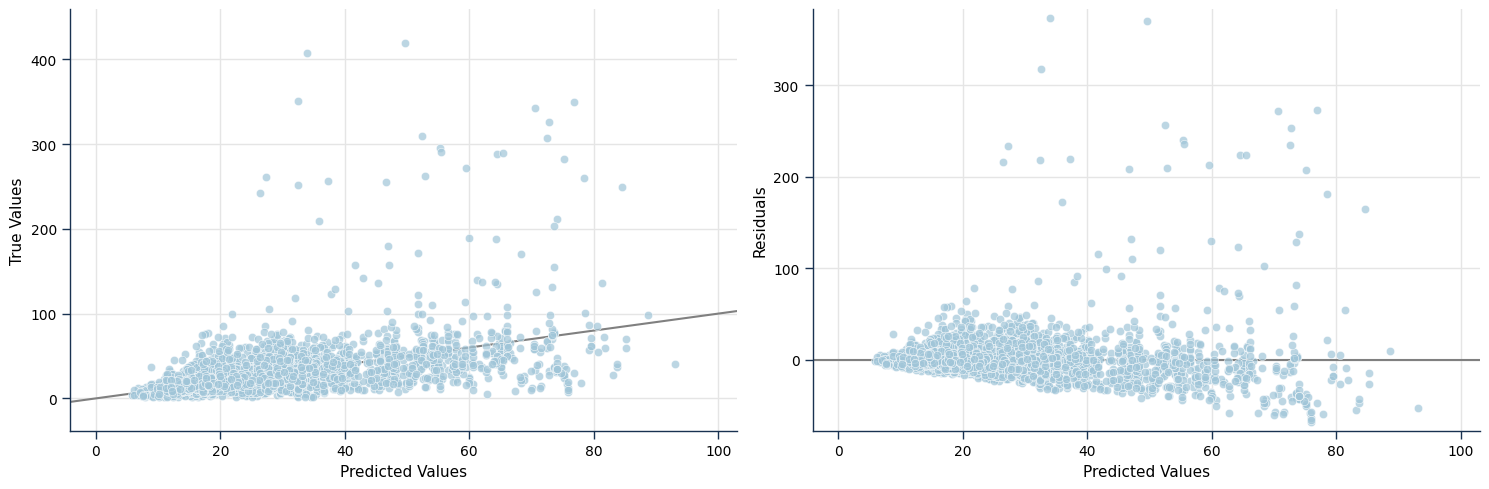

Best Parameters: {'model__algorithm': 'auto', 'model__leaf_size': 20, 'model__metric': 'manhattan', 'model__n_neighbors': 15, 'model__weights': 'uniform'}
Training RMSE: 20.63094108415184
Training R²: 0.2962076910458781
Training Adjusted R²: 0.2862239251260764


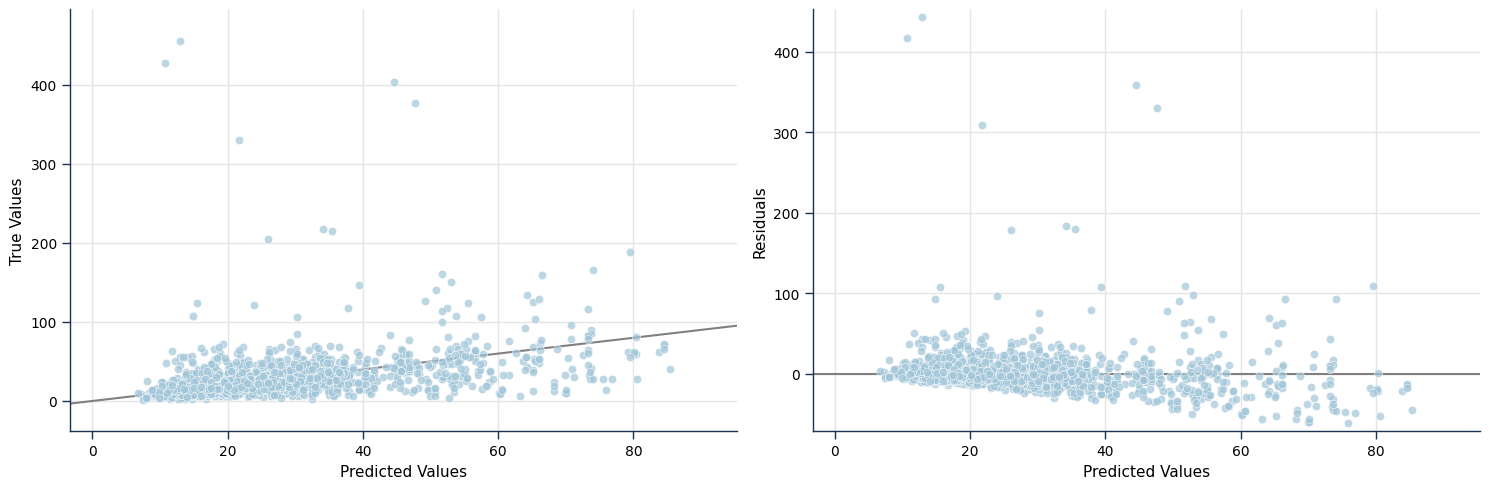

Test RMSE: 23.34021117992191
Test R²: 0.16415438293246198
Test Adjusted R²: 0.13595976134905652


(Pipeline(steps=[('preprocessing',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('drop_uvaerosol_layer_height',
                                                                    DropUvaerosolLayerHeightTransformer(pattern=re.compile('uvaerosollayerheight', re.IGNORECASE))),
                                                                   ('convert_date',
                                                                    ConvertDateTransformer()),
                                                                   ('extract_date_components',
                                                                    ExtractDateComponentsTransformer()),
                                                                   ('drop_date',
                                                                    DropDateTransforme...
                                                    'nitrogendioxide_no2_slant_column_number_

In [20]:
# Define the model
knn_model = KNeighborsRegressor()

# Define the hyperparameter grid for KNN
knn_param_grid = {
    'model__n_neighbors': [3, 5, 7, 10, 15],  # Number of neighbors to use
    'model__weights': ['uniform', 'distance'],  # Weighting function for neighbors
    'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm used to compute the nearest neighbors
    'model__leaf_size': [20, 30, 50],  # Leaf size for ball_tree and kd_tree algorithms
    'model__metric': ['minkowski', 'euclidean', 'manhattan'],  # Distance metric to use
}

# Call training and evaluation function with GridSearchCV
train_and_evaluate_model(knn_model, knn_param_grid, preprocessing_pipeline, search_type='grid', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

**RandomizedSearchCV**

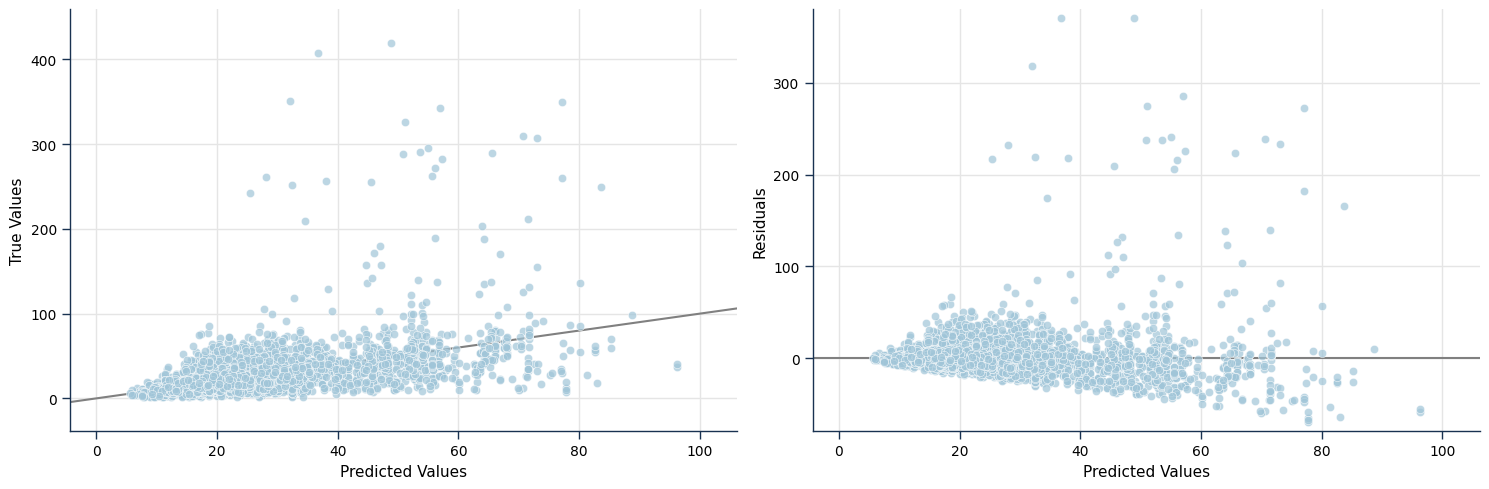

Best Parameters: {'model__weights': 'uniform', 'model__n_neighbors': 15, 'model__metric': 'minkowski', 'model__leaf_size': 50, 'model__algorithm': 'kd_tree'}
Training RMSE: 20.720812823622246
Training R²: 0.2900626679287238
Training Adjusted R²: 0.27999173073467987


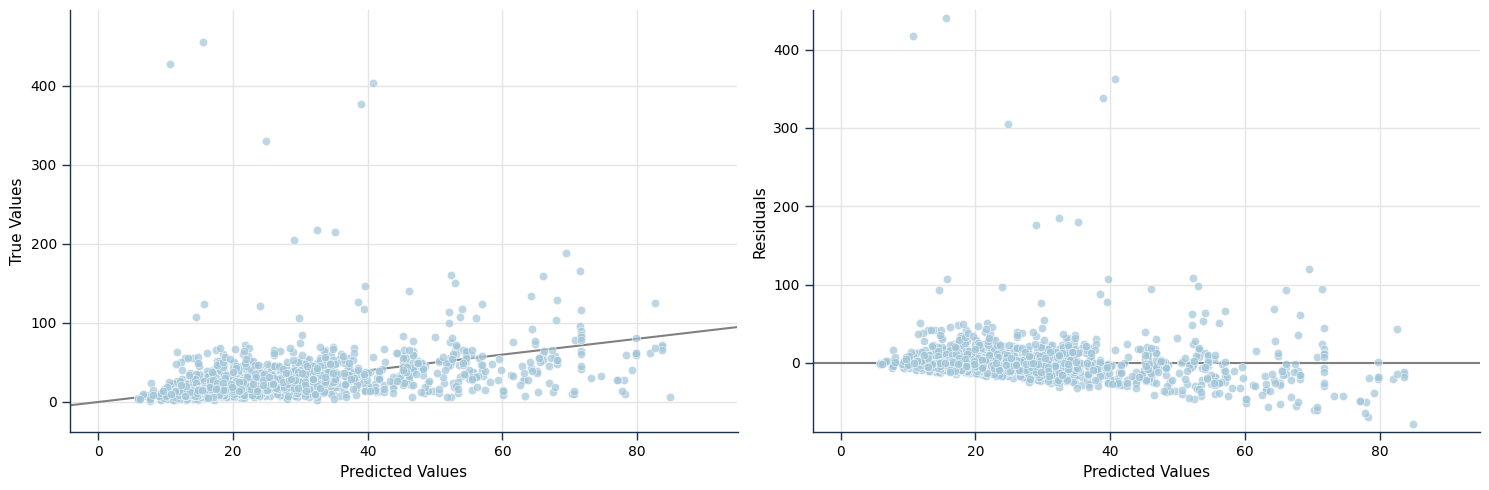

Test RMSE: 23.45403240017982
Test R²: 0.15598231109283922
Test Adjusted R²: 0.12751203038247816


(Pipeline(steps=[('preprocessing',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('drop_uvaerosol_layer_height',
                                                                    DropUvaerosolLayerHeightTransformer(pattern=re.compile('uvaerosollayerheight', re.IGNORECASE))),
                                                                   ('convert_date',
                                                                    ConvertDateTransformer()),
                                                                   ('extract_date_components',
                                                                    ExtractDateComponentsTransformer()),
                                                                   ('drop_date',
                                                                    DropDateTransforme...
                                                    'nitrogendioxide_no2_slant_column_number_

In [21]:
# Call training and evaluation function with RandomSearchCV
train_and_evaluate_model(knn_model, knn_param_grid, preprocessing_pipeline, search_type='random', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

### Descission Tree Regression Model
Decision Tree Regression builds a tree-like model of decisions by splitting the dataset into subsets based on feature values. Each internal node represents a decision on a feature, each branch represents the outcome of that decision, and each leaf node represents a predicted continuous value. Decision trees can capture nonlinear relationships and interactions between features without requiring feature scaling.

In this project, we implemented a decision tree regression model to explore how well it can capture complex, nonlinear patterns in the data and make accurate predictions.

**GridSearchCV**

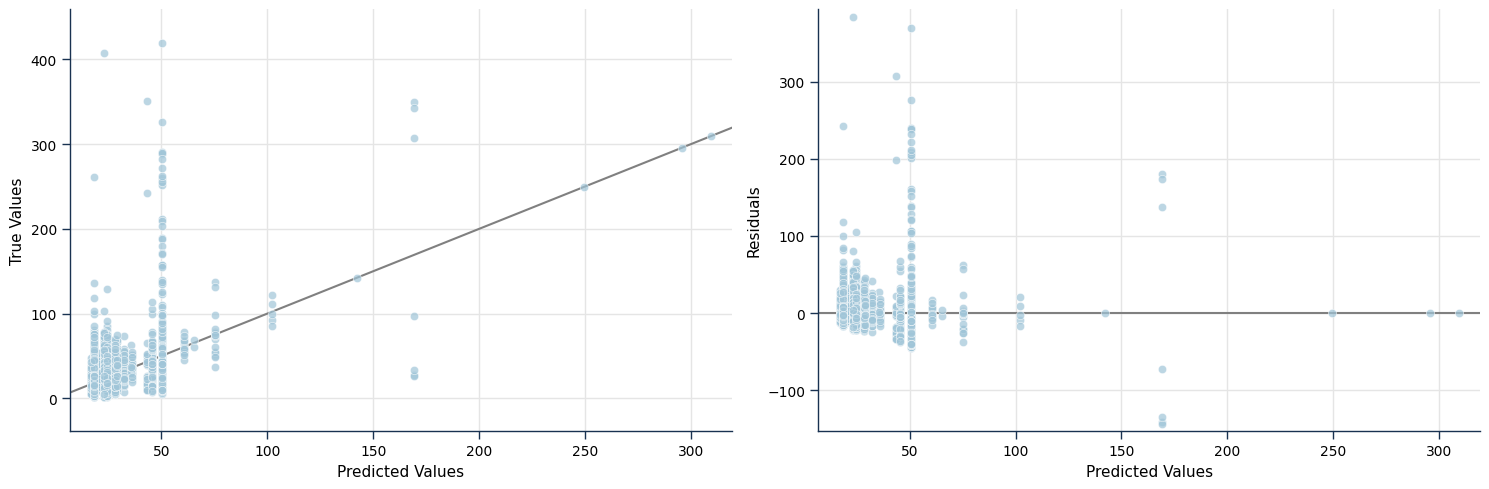

Best Parameters: {'model__criterion': 'squared_error', 'model__max_depth': 5, 'model__min_samples_split': 10}
Training RMSE: 20.971268857743656
Training R²: 0.27279667661003415
Training Adjusted R²: 0.26248080974923194


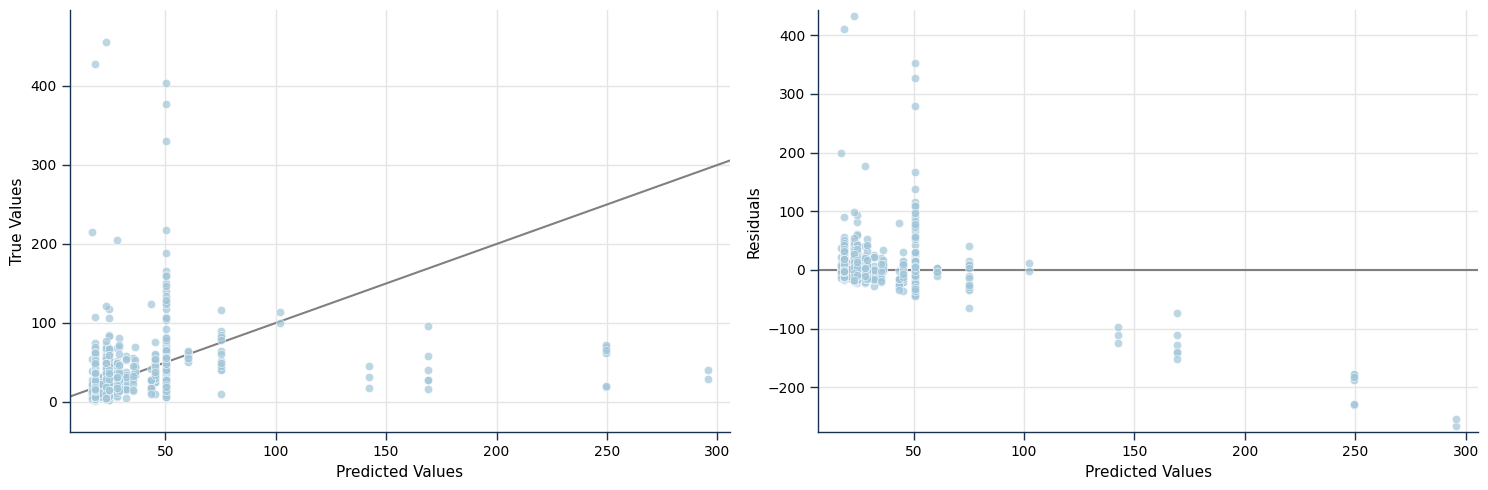

Test RMSE: 27.839457811576487
Test R²: -0.18915386821454216
Test Adjusted R²: -0.22926623183066042


(Pipeline(steps=[('preprocessing',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('drop_uvaerosol_layer_height',
                                                                    DropUvaerosolLayerHeightTransformer(pattern=re.compile('uvaerosollayerheight', re.IGNORECASE))),
                                                                   ('convert_date',
                                                                    ConvertDateTransformer()),
                                                                   ('extract_date_components',
                                                                    ExtractDateComponentsTransformer()),
                                                                   ('drop_date',
                                                                    DropDateTransforme...
                                                    'nitrogendioxide_no2_slant_column_number_

In [27]:
# Define the model
decision_tree_model = DecisionTreeRegressor()

# Define the hyperparameter grid for Decision Tree
decision_tree_param_grid = {
    'model__max_depth': [5, 10, 15],  # Controls the maximum depth of the tree
    'model__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'model__criterion': ['squared_error', 'absolute_error']  # Corrected criteria for splitting nodes
}

# Call training and evaluation function with GridSearchCV
train_and_evaluate_model(decision_tree_model, decision_tree_param_grid, preprocessing_pipeline, search_type='grid', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

**RandomizedSearchCV**

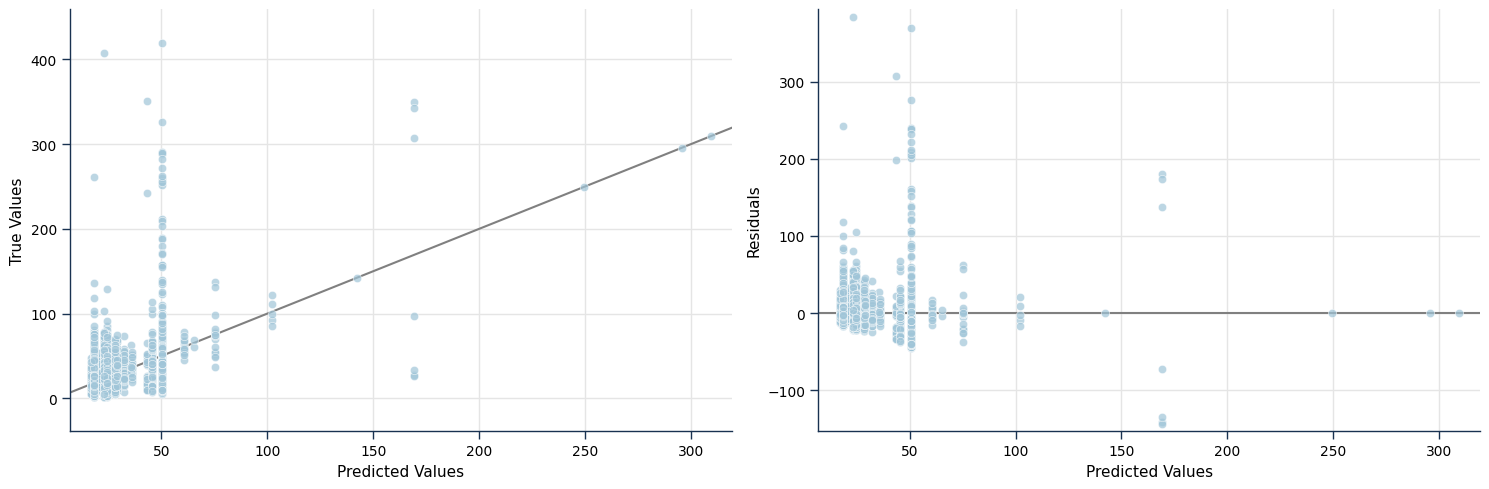

Best Parameters: {'model__min_samples_split': 10, 'model__max_depth': 5, 'model__criterion': 'squared_error'}
Training RMSE: 20.971268857743656
Training R²: 0.27279667661003415
Training Adjusted R²: 0.26248080974923194


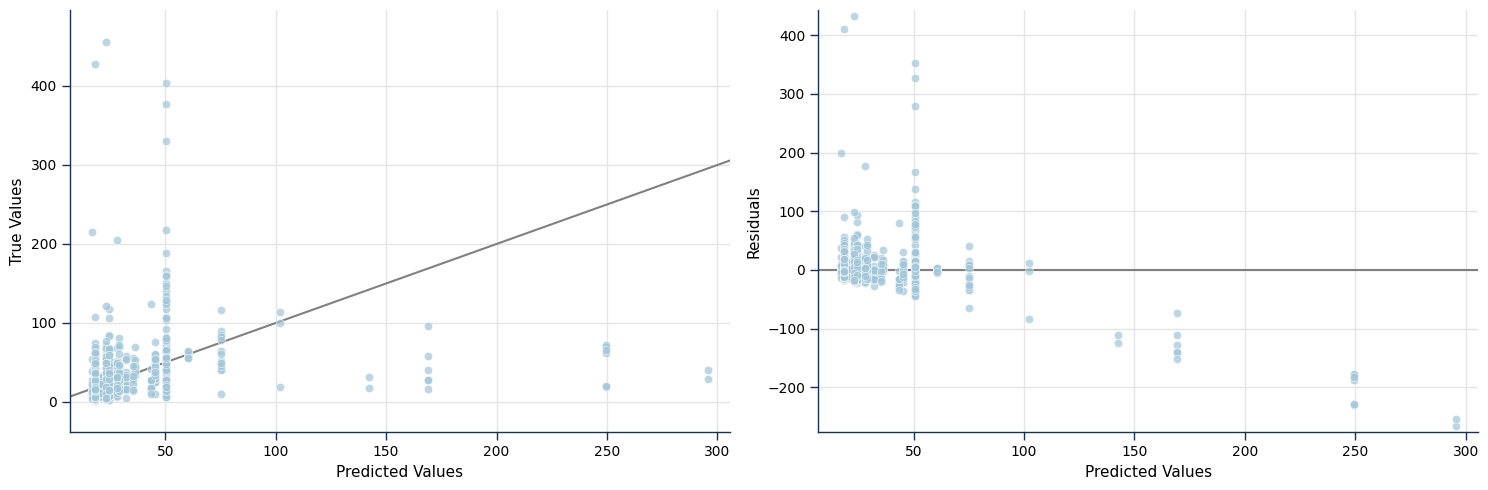

Test RMSE: 27.825351314838564
Test R²: -0.18794906420516355
Test Adjusted R²: -0.2280207875494027


(Pipeline(steps=[('preprocessing',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('drop_uvaerosol_layer_height',
                                                                    DropUvaerosolLayerHeightTransformer(pattern=re.compile('uvaerosollayerheight', re.IGNORECASE))),
                                                                   ('convert_date',
                                                                    ConvertDateTransformer()),
                                                                   ('extract_date_components',
                                                                    ExtractDateComponentsTransformer()),
                                                                   ('drop_date',
                                                                    DropDateTransforme...
                                                    'nitrogendioxide_no2_slant_column_number_

In [28]:
# Call training and evaluation function with RandomSearchCV
train_and_evaluate_model(decision_tree_model, decision_tree_param_grid, preprocessing_pipeline, search_type='random', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

### Random  Forest Regression Model
Random Forest Regression is an ensemble learning method that constructs multiple decision trees during training and outputs the average prediction of the individual trees. By aggregating the results of many trees, random forests reduce the risk of overfitting associated with individual decision trees and improve generalization. The method introduces randomness by selecting random subsets of features and data samples.

In this project, we implemented a random forest regression model to evaluate how ensemble methods can enhance predictive performance by combining multiple decision trees.

**GridSearchCV**

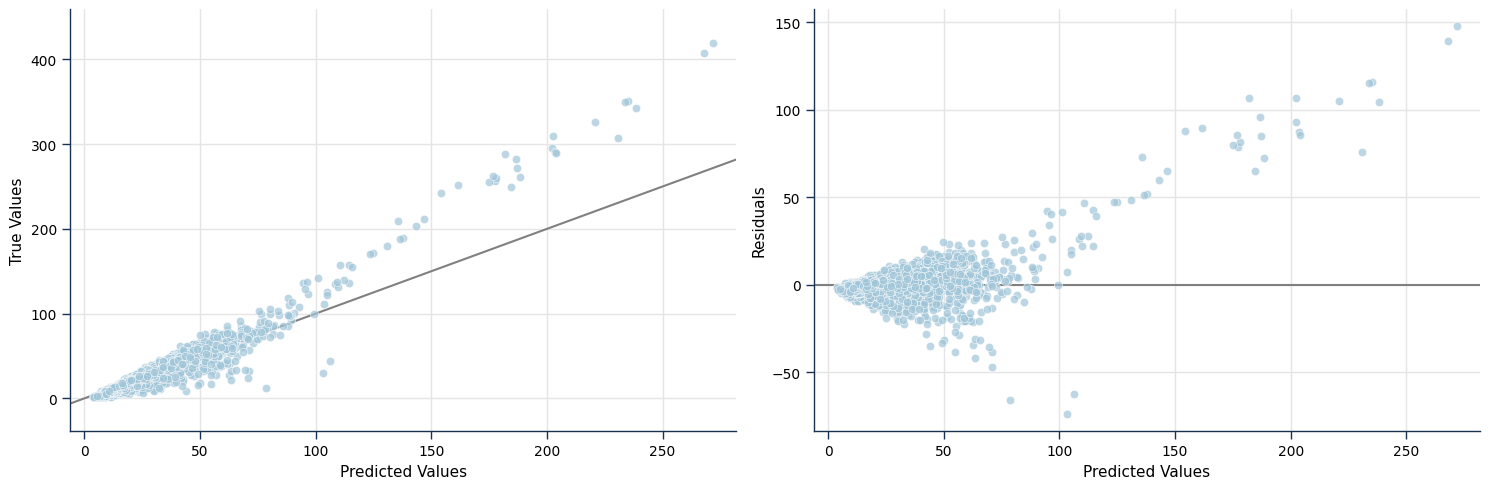

Best Parameters: {'model__max_depth': None, 'model__max_features': 'log2', 'model__n_estimators': 500}
Training RMSE: 8.321071932015622
Training R²: 0.8855106758980573
Training Adjusted R²: 0.8838865680503192


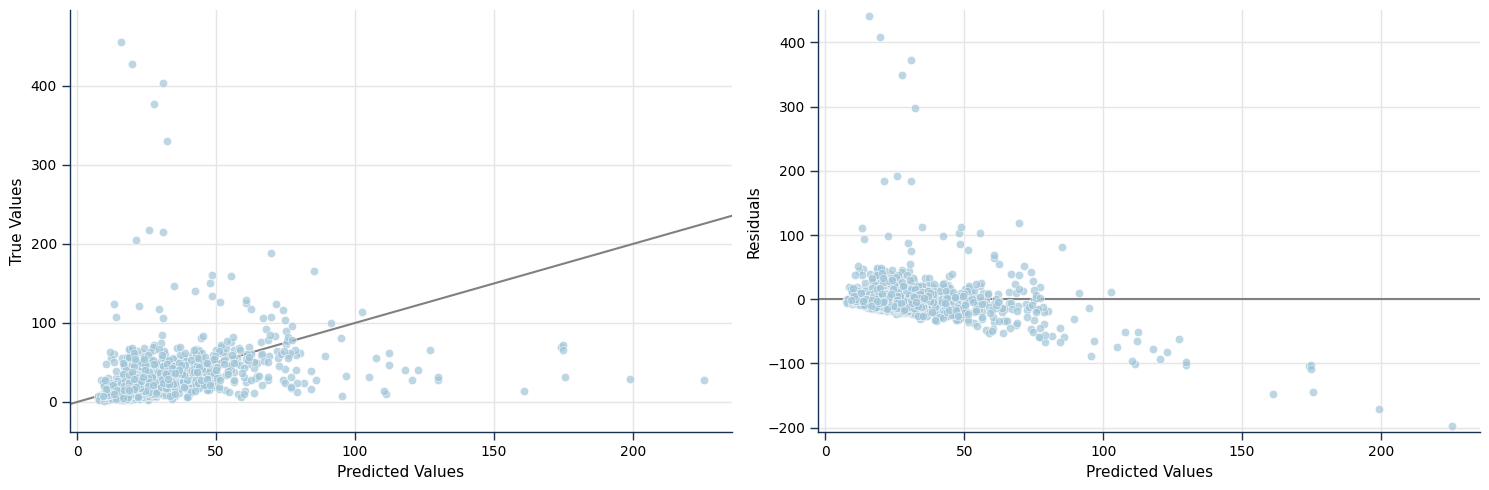

Test RMSE: 25.04094065779078
Test R²: 0.03790538202255389
Test Adjusted R²: 0.0054521476842882555


(Pipeline(steps=[('preprocessing',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('drop_uvaerosol_layer_height',
                                                                    DropUvaerosolLayerHeightTransformer(pattern=re.compile('uvaerosollayerheight', re.IGNORECASE))),
                                                                   ('convert_date',
                                                                    ConvertDateTransformer()),
                                                                   ('extract_date_components',
                                                                    ExtractDateComponentsTransformer()),
                                                                   ('drop_date',
                                                                    DropDateTransforme...
                                                    'nitrogendioxide_no2_slant_column_number_

In [29]:
# Define the model
random_forest_model = RandomForestRegressor()

# Define the hyperparameter grid for Random Forest
random_forest_param_grid = {
    'model__n_estimators': [100, 200, 500],  # Number of trees in the forest
    'model__max_depth': [10, 20, None],  # Maximum depth of each tree (None means nodes are expanded until all leaves are pure)
    'model__max_features': ['sqrt', 'log2']  # Number of features to consider at each split
}

# Call training and evaluation function with GridSearchCV
train_and_evaluate_model(random_forest_model, random_forest_param_grid, preprocessing_pipeline, search_type='grid', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

**RandomizedSearchCV**

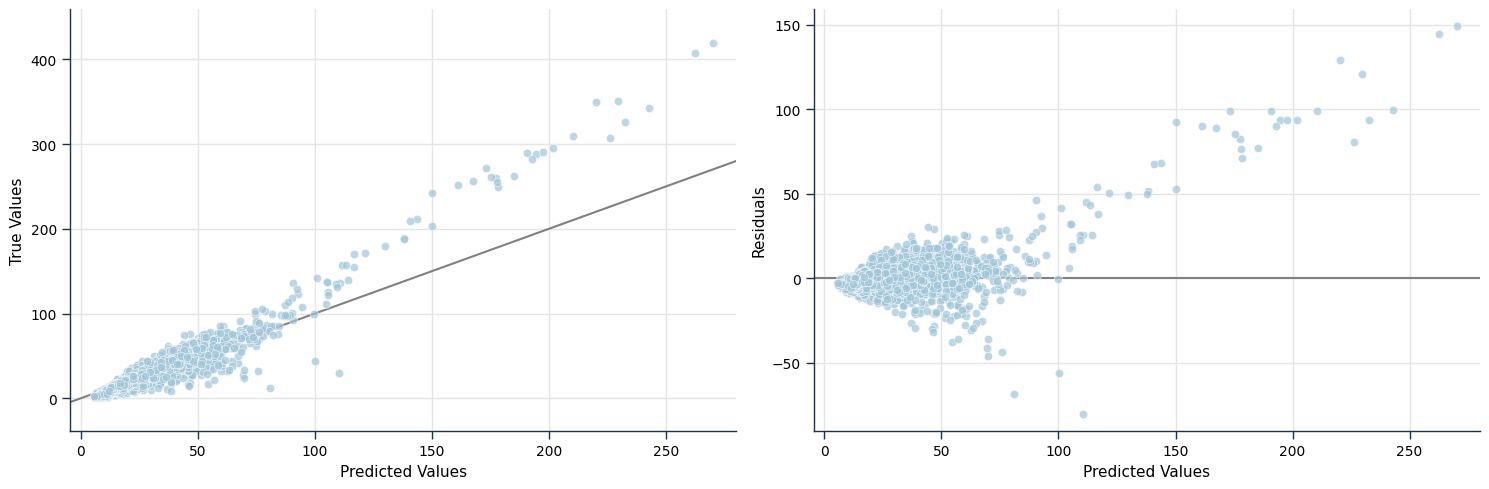

Best Parameters: {'model__n_estimators': 500, 'model__max_features': 'log2', 'model__max_depth': 20}
Training RMSE: 8.772599848117435
Training R²: 0.8727484506441217
Training Adjusted R²: 0.870943302071826


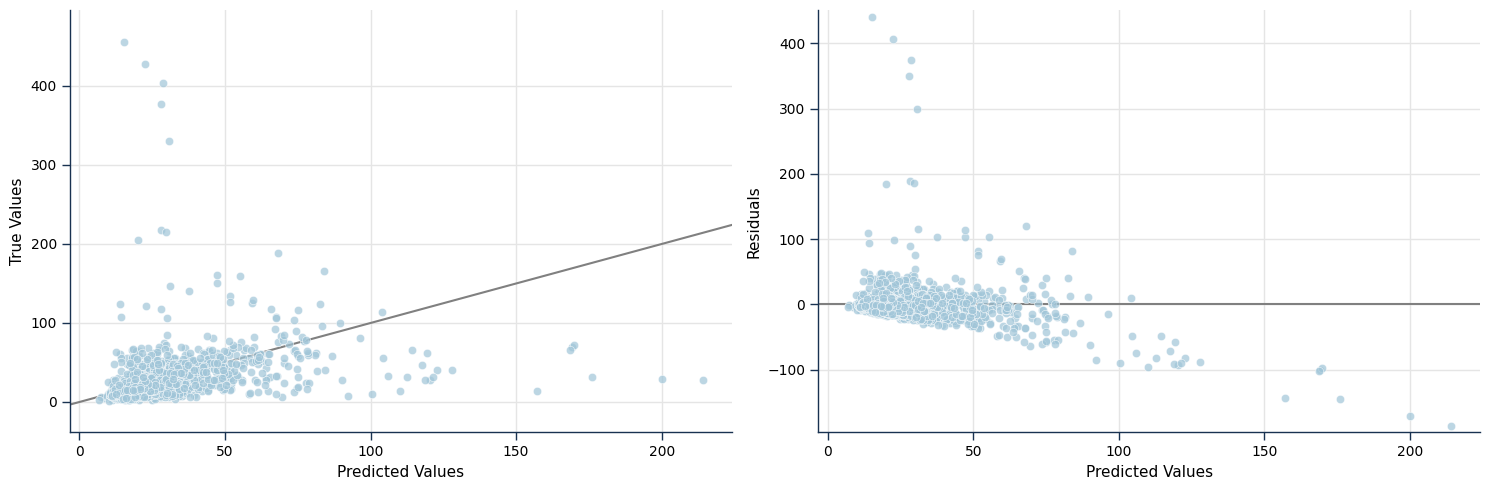

Test RMSE: 24.95137189542815
Test R²: 0.044775691606532164
Test Adjusted R²: 0.01255420554202158


(Pipeline(steps=[('preprocessing',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('drop_uvaerosol_layer_height',
                                                                    DropUvaerosolLayerHeightTransformer(pattern=re.compile('uvaerosollayerheight', re.IGNORECASE))),
                                                                   ('convert_date',
                                                                    ConvertDateTransformer()),
                                                                   ('extract_date_components',
                                                                    ExtractDateComponentsTransformer()),
                                                                   ('drop_date',
                                                                    DropDateTransforme...
                                                    'nitrogendioxide_no2_slant_column_number_

In [30]:
# Call training and evaluation function with RandomSearchCV
train_and_evaluate_model(random_forest_model, random_forest_param_grid, preprocessing_pipeline, search_type='random', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

### AdaBoost Regression Model
Adaptive Boosting (AdaBoost) is an ensemble technique that combines multiple weak learners to create a strong predictive model. In regression, AdaBoost adjusts the weights of data points iteratively, focusing more on observations that previous models predicted poorly. By emphasizing difficult cases, AdaBoost can improve overall model accuracy.

In this project, we implemented an AdaBoost regression model to investigate how boosting techniques can enhance prediction accuracy by sequentially correcting the errors of weaker models.

**GridSearchCV**

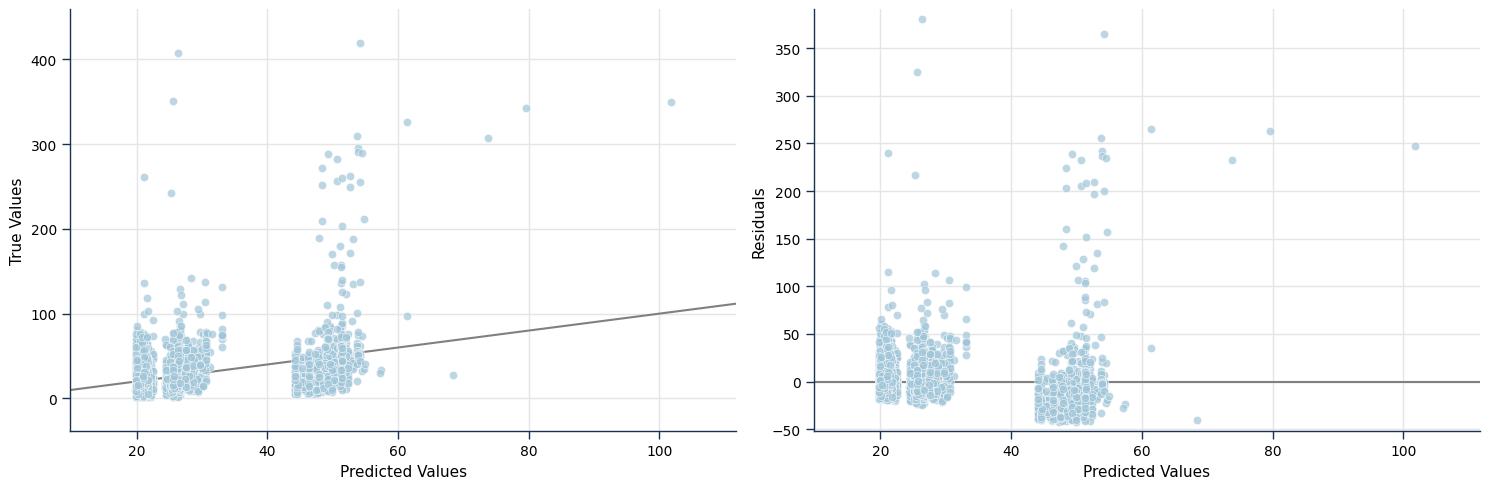

Best Parameters: {'model__learning_rate': 0.01, 'model__loss': 'exponential', 'model__n_estimators': 100}
Training RMSE: 22.495988154492387
Training R²: 0.1632097945582195
Training Adjusted R²: 0.15133936427811523


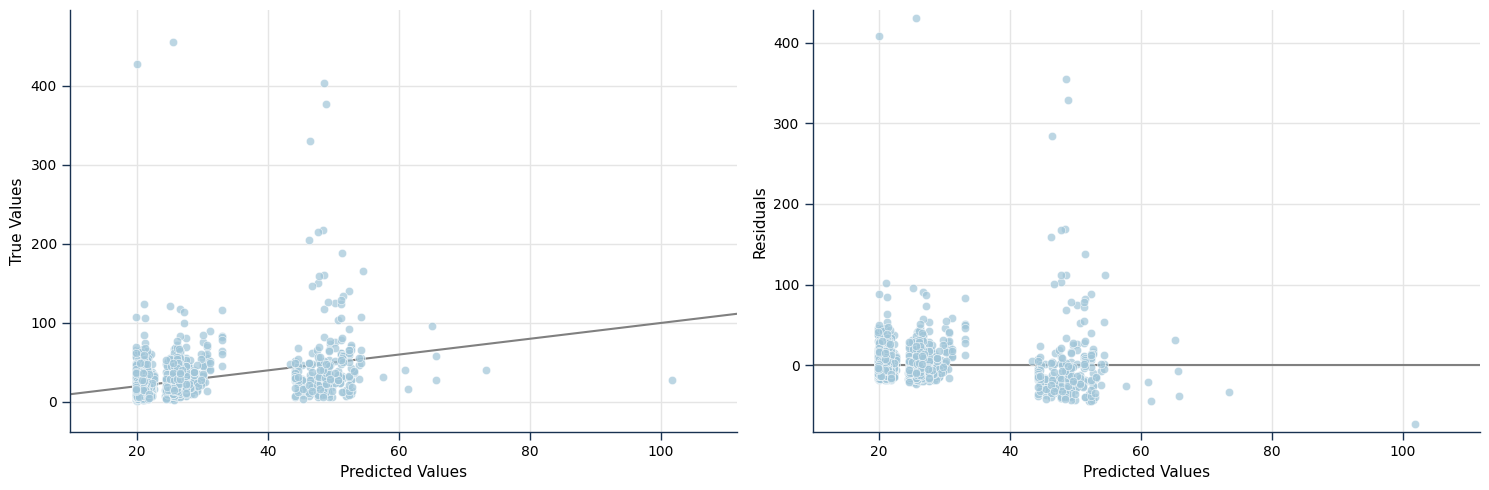

Test RMSE: 24.185323341950173
Test R²: 0.10252925002775237
Test Adjusted R²: 0.07225589851289005


(Pipeline(steps=[('preprocessing',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('drop_uvaerosol_layer_height',
                                                                    DropUvaerosolLayerHeightTransformer(pattern=re.compile('uvaerosollayerheight', re.IGNORECASE))),
                                                                   ('convert_date',
                                                                    ConvertDateTransformer()),
                                                                   ('extract_date_components',
                                                                    ExtractDateComponentsTransformer()),
                                                                   ('drop_date',
                                                                    DropDateTransforme...
                                                    'nitrogendioxide_no2_slant_column_number_

In [31]:
# Define the model
ada_boost_model = AdaBoostRegressor()

# Define the hyperparameter grid for AdaBoost
ada_boost_param_grid = {
    'model__n_estimators': [50, 100, 200],  # Number of boosting stages
    'model__learning_rate': [0.01, 0.05, 0.1],  # Learning rate controlling the contribution of each regressor
    'model__loss': ['linear', 'square', 'exponential']  # Loss function to use
}

# Call training and evaluation function with GridSearchCV
train_and_evaluate_model(ada_boost_model, ada_boost_param_grid, preprocessing_pipeline, search_type='grid', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

**RandomizedSearchCV**

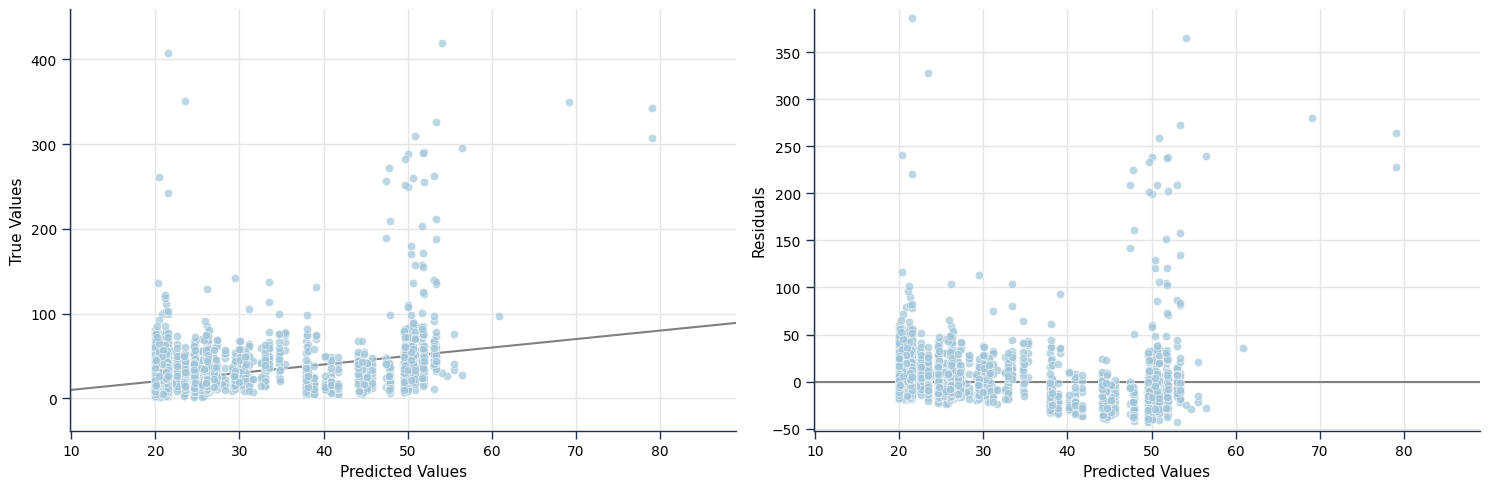

Best Parameters: {'model__n_estimators': 50, 'model__loss': 'linear', 'model__learning_rate': 0.01}
Training RMSE: 22.428175994273943
Training R²: 0.16824705056882827
Training Adjusted R²: 0.15644807714360598


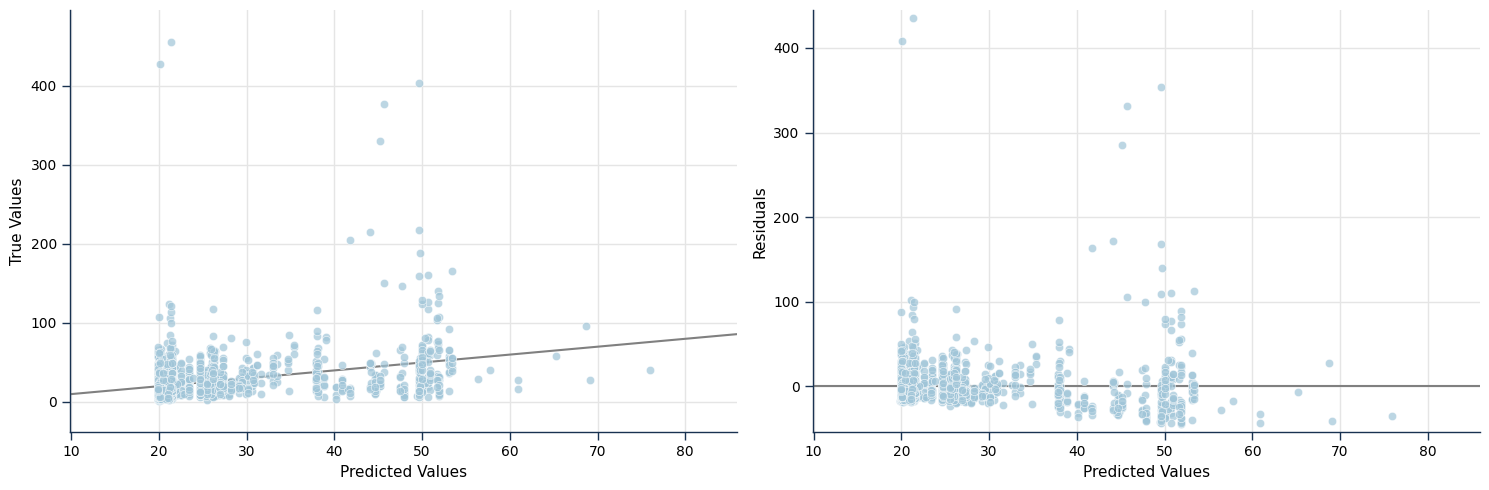

Test RMSE: 24.092092564165775
Test R²: 0.10943514279595479
Test Adjusted R²: 0.07939473984159129


(Pipeline(steps=[('preprocessing',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('drop_uvaerosol_layer_height',
                                                                    DropUvaerosolLayerHeightTransformer(pattern=re.compile('uvaerosollayerheight', re.IGNORECASE))),
                                                                   ('convert_date',
                                                                    ConvertDateTransformer()),
                                                                   ('extract_date_components',
                                                                    ExtractDateComponentsTransformer()),
                                                                   ('drop_date',
                                                                    DropDateTransforme...
                                                    'nitrogendioxide_stratospheric_no2_column

In [32]:
# Call training and evaluation function with RandomSearchCV
train_and_evaluate_model(ada_boost_model, ada_boost_param_grid, preprocessing_pipeline, search_type='random', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

### XGBoost Model
Extreme Gradient Boosting (XGBoost) is an optimized gradient boosting framework that uses advanced regularization techniques (L1 and L2) to prevent overfitting and improve performance. XGBoost is known for its speed and efficiency, thanks to features like parallel processing and tree pruning. It excels in handling large datasets and complex patterns.

In this project, we implemented an XGBoost regression model to leverage its powerful gradient boosting capabilities and assess its effectiveness in capturing intricate patterns in the data.

**GridSearchCV**

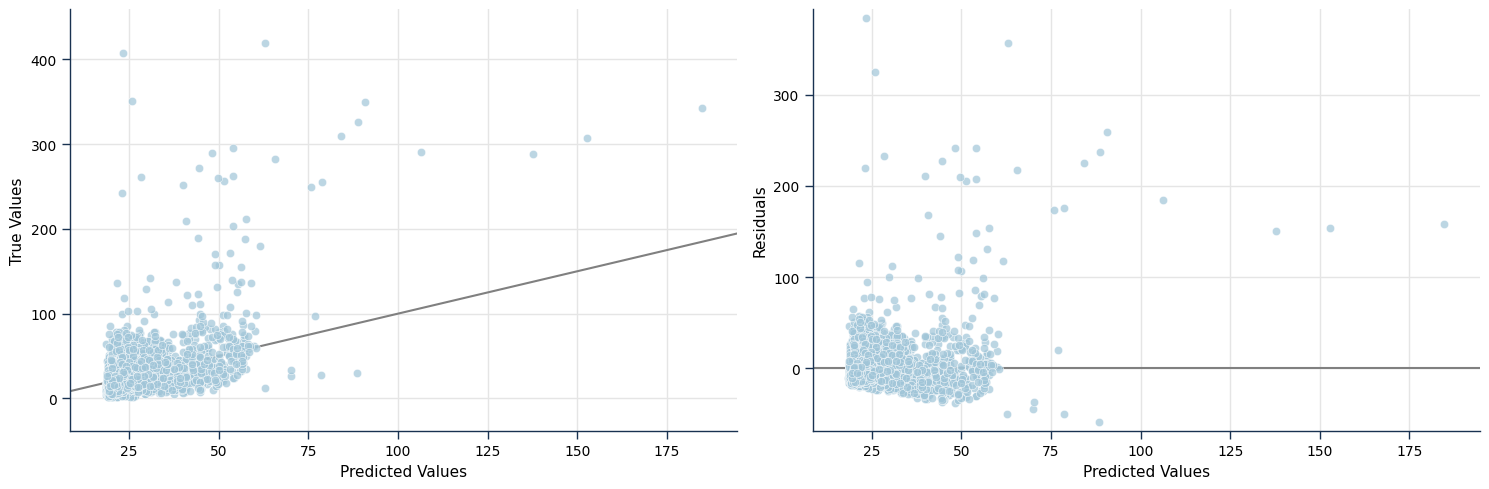

Best Parameters: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 200}
Training RMSE: 20.83906037456683
Training R²: 0.28193674296968585
Training Adjusted R²: 0.2717505340802272


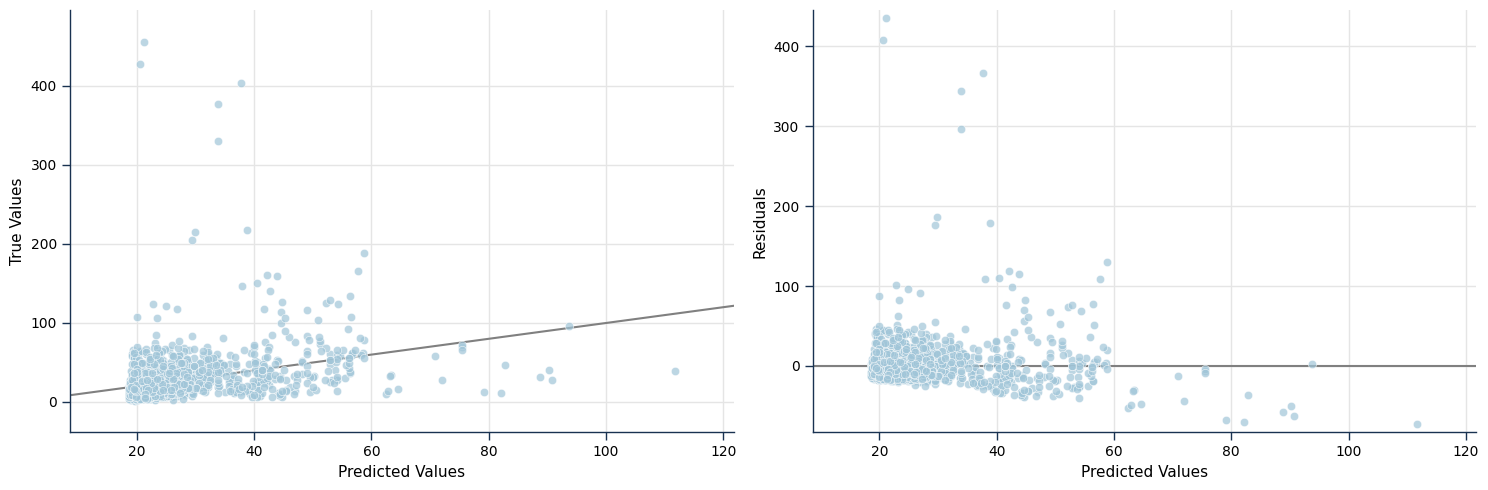

Test RMSE: 23.9963136265671
Test R²: 0.11650200960147195
Test Adjusted R²: 0.0866999851601894


(Pipeline(steps=[('preprocessing',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('drop_uvaerosol_layer_height',
                                                                    DropUvaerosolLayerHeightTransformer(pattern=re.compile('uvaerosollayerheight', re.IGNORECASE))),
                                                                   ('convert_date',
                                                                    ConvertDateTransformer()),
                                                                   ('extract_date_components',
                                                                    ExtractDateComponentsTransformer()),
                                                                   ('drop_date',
                                                                    DropDateTransforme...
                               feature_types=None, gamma=None, grow_policy=None,
            

In [33]:
# Define the model
xgboost_model = xgb.XGBRegressor()

# Define the hyperparameter grid for XGBoost
xgboost_param_grid = {
    'model__n_estimators': [100, 200, 500],  # Number of boosting rounds
    'model__learning_rate': [0.01, 0.05, 0.1],  # Learning rate controlling the contribution of each tree
    'model__max_depth': [3, 5, 7]  # Maximum depth of a tree
}

# Call training and evaluation function with GridSearchCV
train_and_evaluate_model(xgboost_model, xgboost_param_grid, preprocessing_pipeline, search_type='grid', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

**RandomizedSearchCV**

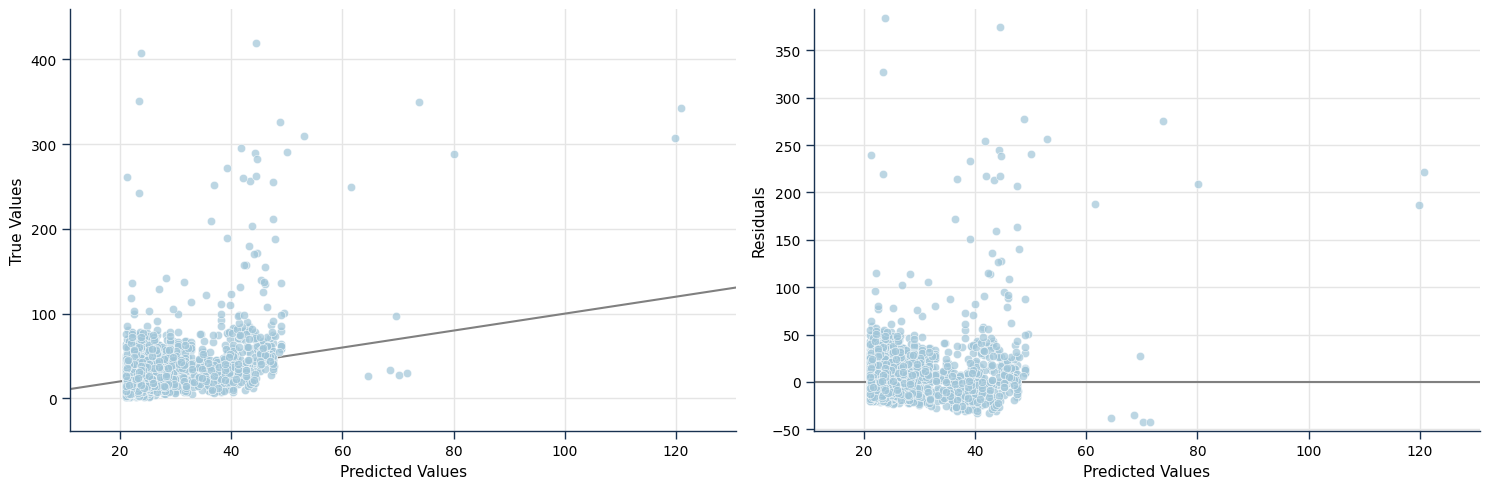

Best Parameters: {'model__n_estimators': 100, 'model__max_depth': 3, 'model__learning_rate': 0.01}
Training RMSE: 22.03271071584614
Training R²: 0.19732025602928704
Training Adjusted R²: 0.18593370552225064


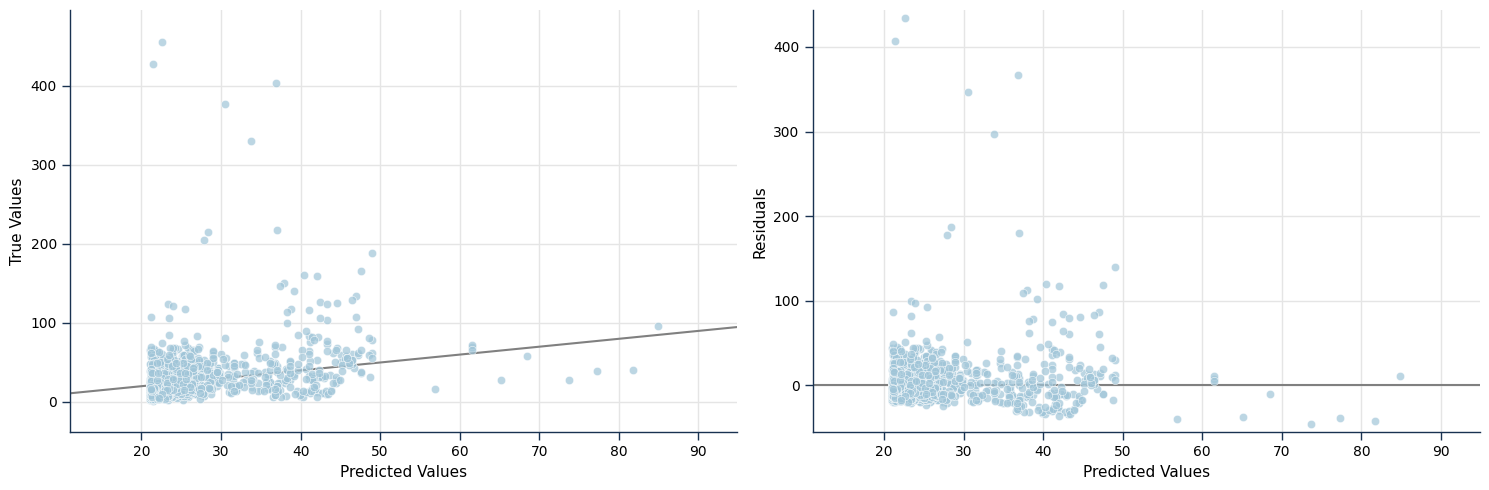

Test RMSE: 24.085362704107837
Test R²: 0.10993261222528827
Test Adjusted R²: 0.07990898983664507


In [34]:
# Call training and evaluation function with RandomSearchCV
best_model, test_metrics, y_test_pred = train_and_evaluate_model(xgboost_model, xgboost_param_grid, preprocessing_pipeline, search_type='random', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

### Support Vector Machine (SVM) Model
Support Vector Machine (SVM) is a powerful supervised learning algorithm commonly used for classification and regression tasks. In regression, the SVM algorithm (SVR) seeks to find a hyperplane that best fits the data by maximizing the margin within an acceptable error tolerance. SVR is particularly effective for handling high-dimensional data and non-linear relationships through the use of various kernel functions.

In this project, we implemented a Support Vector Regression (SVR) model to explore its ability to model complex, non-linear relationships in the data, leveraging its kernel-based approach for flexibility and robustness.

**GridSearchCV**

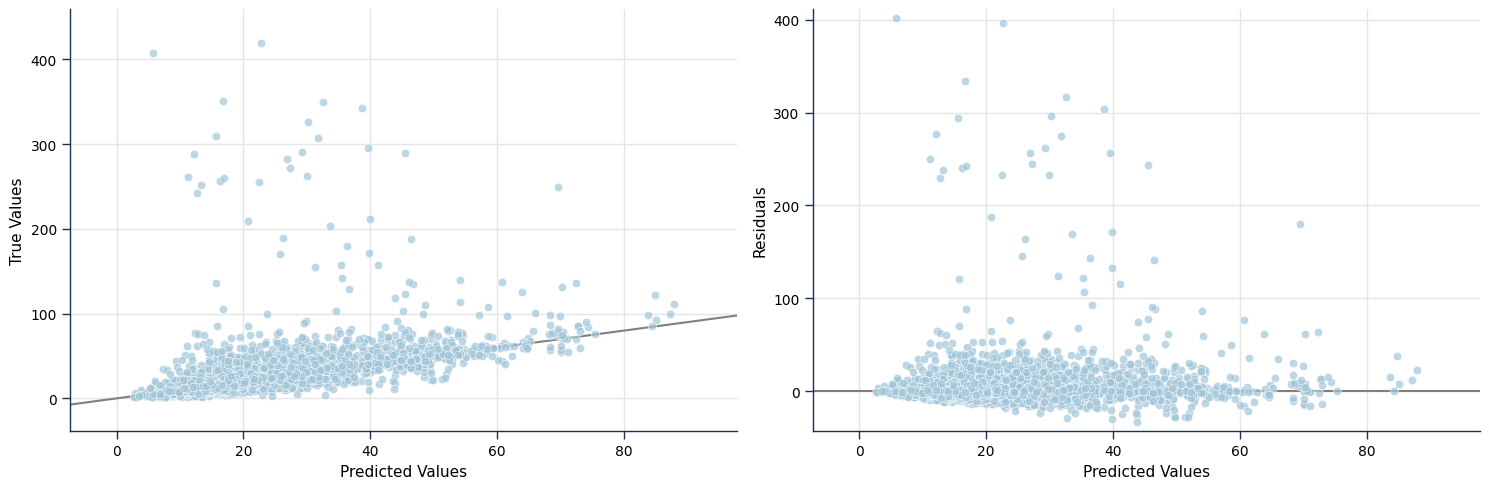

Best Parameters: {'model__C': 100, 'model__epsilon': 0.5, 'model__kernel': 'rbf'}
Training RMSE: 21.13608541815966
Training R²: 0.26132134512566596
Training Adjusted R²: 0.2508426929915176


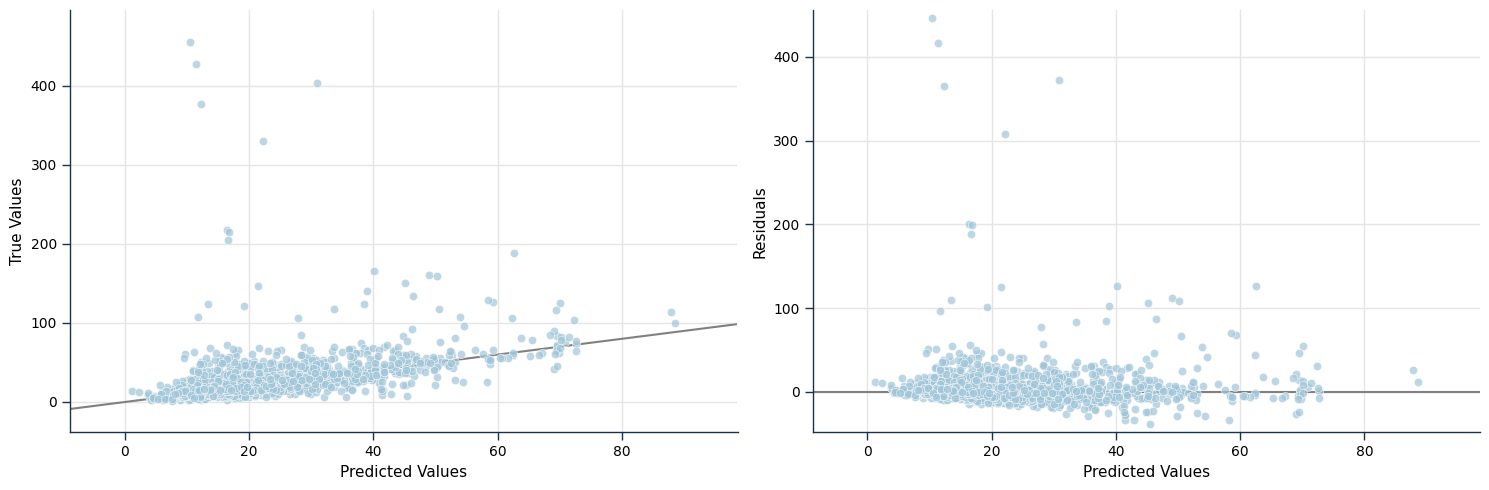

Test RMSE: 22.91429871483071
Test R²: 0.19438109725116648
Test Adjusted R²: 0.16720607875536886


In [40]:
# Define the SVM regression model
svm_model = SVR()

# Define the hyperparameter grid for SVM
svm_param_grid = {
    'model__C': [40, 50, 75, 100],  # Regularization parameter
    'model__epsilon': [0.005, 0.01, 0.02, 0.5],  # Epsilon in the epsilon-SVR model
    'model__kernel': ['linear', 'rbf', 'poly']  # Kernel type
}

# Call the training and evaluation function with GridSearchCV for SVM
best_model, test_metrics, y_test_pred = train_and_evaluate_model(svm_model, svm_param_grid, preprocessing_pipeline, search_type='grid', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)


# Convert the predicted values to a pandas DataFrame
y_test_pred_df = pd.DataFrame(y_test_pred, columns=['PM2.5_Prediction'])

# Save y_test_pred to a CSV file
y_test_pred_df.to_csv("../data/y_test_pred.csv", index=False)

**RandomizedSearchCV**

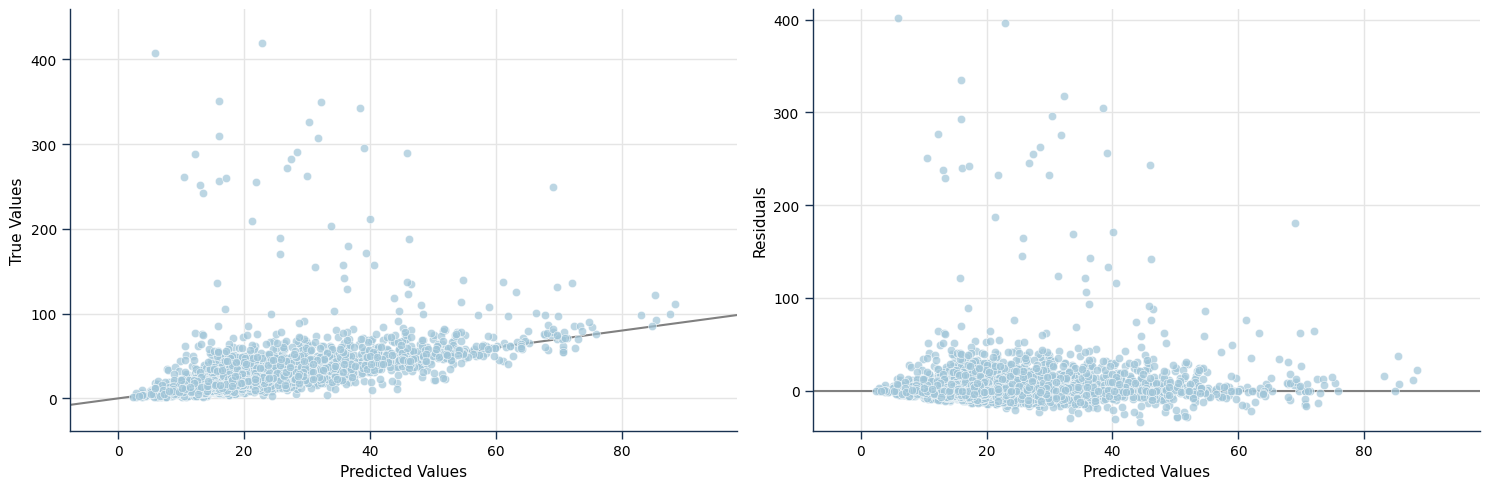

Best Parameters: {'model__kernel': 'rbf', 'model__epsilon': 0.02, 'model__C': 100}
Training RMSE: 21.149234810059898
Training R²: 0.2604019509845408
Training Adjusted R²: 0.24991025662788402


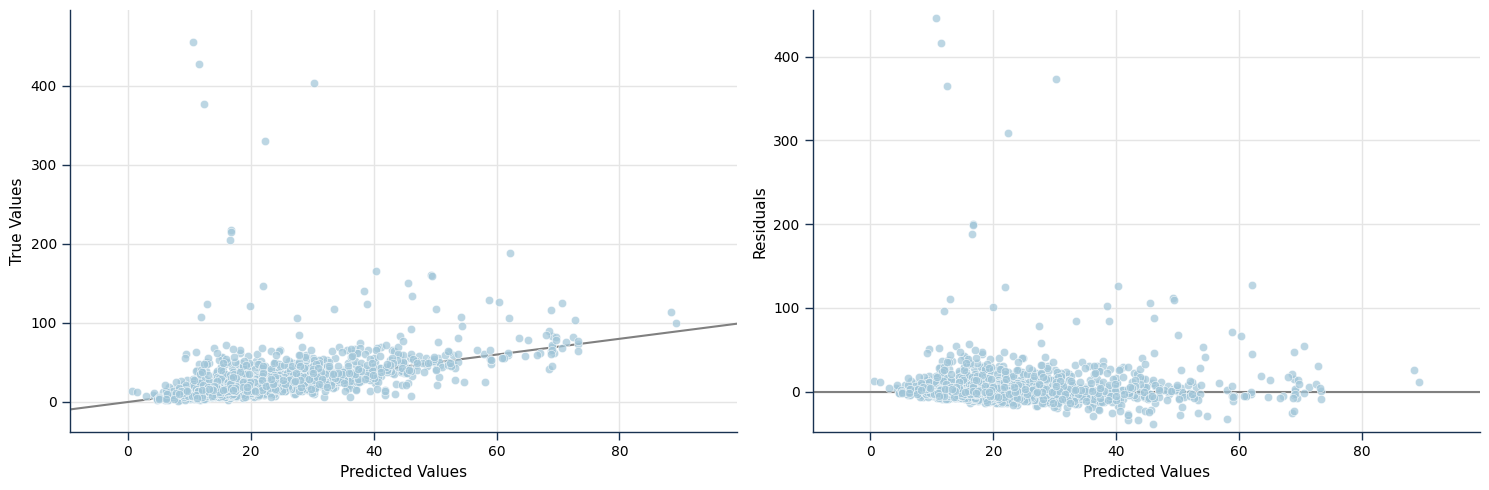

Test RMSE: 22.915294184071453
Test R²: 0.194311098490353
Test Adjusted R²: 0.1671337188066373


(Pipeline(steps=[('preprocessing',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('drop_uvaerosol_layer_height',
                                                                    DropUvaerosolLayerHeightTransformer(pattern=re.compile('uvaerosollayerheight', re.IGNORECASE))),
                                                                   ('convert_date',
                                                                    ConvertDateTransformer()),
                                                                   ('extract_date_components',
                                                                    ExtractDateComponentsTransformer()),
                                                                   ('drop_date',
                                                                    DropDateTransforme...
                                                    'nitrogendioxide_stratospheric_no2_column

In [41]:
# Call the training and evaluation function with GridSearchCV for SVM
train_and_evaluate_model(svm_model, svm_param_grid, preprocessing_pipeline, search_type='random', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

### Feedforward Neural Network Model - Multilayer Perceptron (MLP)
A Multilayer Perceptron (MLP) is a class of feedforward artificial neural network that consists of an input layer, one or more hidden layers, and an output layer. Each neuron in the network applies a nonlinear activation function, allowing the model to capture complex nonlinear relationships between inputs and outputs. MLPs are trained using backpropagation to minimize the loss function.

In this project, we implemented a feedforward neural network (MLP) regression model to explore how deep learning techniques can capture intricate patterns in the data and improve prediction accuracy over traditional models.

**GridSearchCV**

Received parameters: n_neurons=64, learning_rate=0.001, input_shape=(70,)
Received parameters: n_neurons=64, learning_rate=0.001, input_shape=(70,)
Received parameters: n_neurons=64, learning_rate=0.001, input_shape=(70,)
Received parameters: n_neurons=64, learning_rate=0.001, input_shape=(70,)
Received parameters: n_neurons=64, learning_rate=0.001, input_shape=(70,)
Received parameters: n_neurons=128, learning_rate=0.001, input_shape=(70,)
Received parameters: n_neurons=128, learning_rate=0.001, input_shape=(70,)
Received parameters: n_neurons=128, learning_rate=0.001, input_shape=(70,)
Received parameters: n_neurons=128, learning_rate=0.001, input_shape=(70,)
Received parameters: n_neurons=128, learning_rate=0.001, input_shape=(70,)
Received parameters: n_neurons=256, learning_rate=0.001, input_shape=(70,)
Received parameters: n_neurons=256, learning_rate=0.001, input_shape=(70,)
Received parameters: n_neurons=256, learning_rate=0.001, input_shape=(70,)
Received parameters: n_neurons

2024-10-05 21:41:05.122141: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at resource_variable_ops.cc:620 : INVALID_ARGUMENT: Cannot update variable with shape [128,1] using a Tensor with shape [128,0], shapes must be equal.
2024-10-05 21:41:05.122558: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Cannot update variable with shape [128,1] using a Tensor with shape [128,0], shapes must be equal.
	 [[{{function_node __inference_one_step_on_data_317506}}{{node adam/AssignSubVariableOp_4}}]]


Received parameters: n_neurons=128, learning_rate=0.001, input_shape=(70,)
Received parameters: n_neurons=128, learning_rate=0.001, input_shape=(70,)
Received parameters: n_neurons=128, learning_rate=0.001, input_shape=(70,)
Received parameters: n_neurons=256, learning_rate=0.001, input_shape=(70,)
Received parameters: n_neurons=256, learning_rate=0.001, input_shape=(70,)
Received parameters: n_neurons=256, learning_rate=0.001, input_shape=(70,)
Received parameters: n_neurons=256, learning_rate=0.001, input_shape=(70,)
Received parameters: n_neurons=256, learning_rate=0.001, input_shape=(70,)
Received parameters: n_neurons=256, learning_rate=0.001, input_shape=(70,)


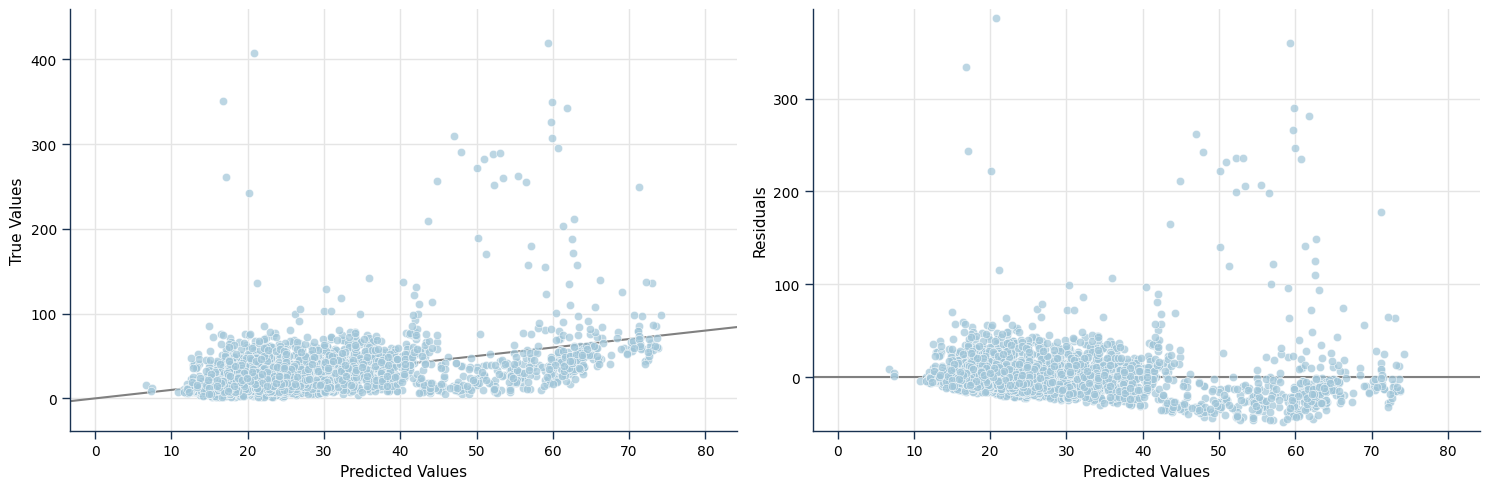

Best Parameters: {'model__model__activation': 'tanh', 'model__model__n_layers': 3, 'model__model__n_neurons': 256}
Training RMSE: 21.963943370926746
Training R²: 0.2023230007869855
Training Adjusted R²: 0.19100741756956252


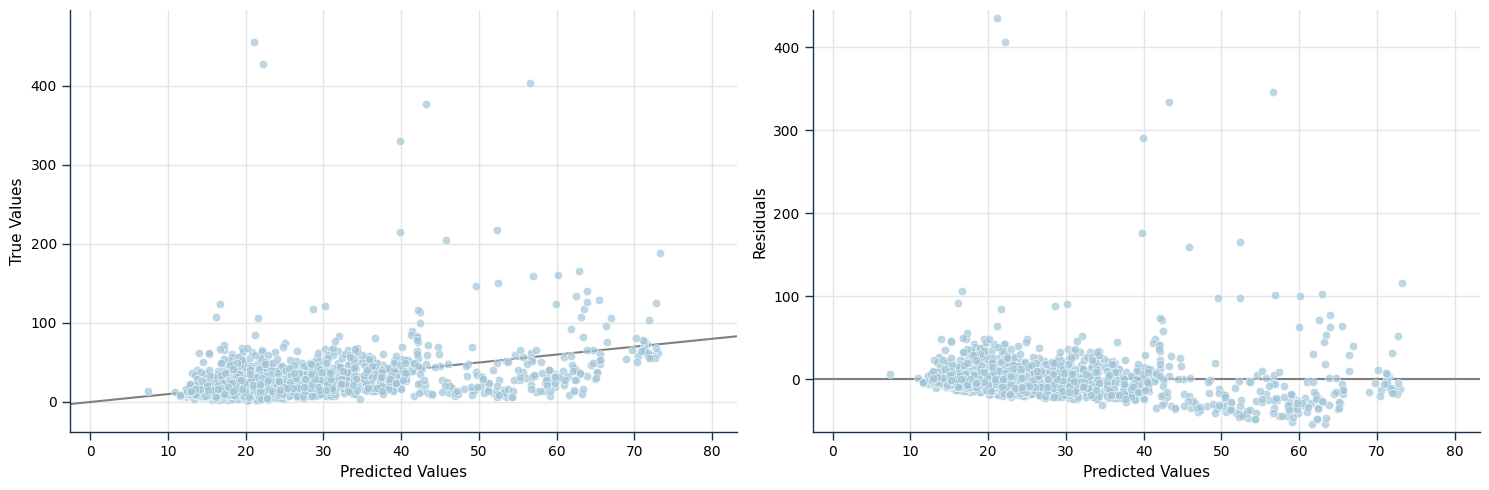

Test RMSE: 23.59065039184221
Test R²: 0.14612099344196317
Test Adjusted R²: 0.11731807221306267


(Pipeline(steps=[('preprocessing',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('drop_uvaerosol_layer_height',
                                                                    DropUvaerosolLayerHeightTransformer(pattern=re.compile('uvaerosollayerheight', re.IGNORECASE))),
                                                                   ('convert_date',
                                                                    ConvertDateTransformer()),
                                                                   ('extract_date_components',
                                                                    ExtractDateComponentsTransformer()),
                                                                   ('drop_date',
                                                                    DropDateTransforme...
                                                    'nitrogendioxide_absorbing_aerosol_index'

In [42]:
# Define the model
n_features_after_pca = fixed_n_components + 8 # The categorical pipeline produces 8 one-hot encoded features

mlp_model = KerasRegressor(
    model=create_mlp_model,
    verbose=0,
    model__input_shape=(n_features_after_pca,)
)

# Define the hyperparameter grid for MLP
mlp_param_grid = {
    'model__model__n_neurons': [64, 128, 256],  # Number of neurons in each hidden layer
    'model__model__n_layers': [1, 2, 3],       # Number of hidden layers
    'model__model__activation': ['relu', 'tanh']  # Activation function
}

# Call training and evaluation function with GridSearchCV
train_and_evaluate_model(
    mlp_model,
    mlp_param_grid,
    preprocessing_pipeline,
    search_type='grid',
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test
)

**RandomSearchCV**

Received parameters: n_neurons=64, learning_rate=0.001, input_shape=(70,)
Received parameters: n_neurons=64, learning_rate=0.001, input_shape=(70,)
Received parameters: n_neurons=64, learning_rate=0.001, input_shape=(70,)
Received parameters: n_neurons=64, learning_rate=0.001, input_shape=(70,)
Received parameters: n_neurons=64, learning_rate=0.001, input_shape=(70,)
Received parameters: n_neurons=128, learning_rate=0.001, input_shape=(70,)
Received parameters: n_neurons=128, learning_rate=0.001, input_shape=(70,)
Received parameters: n_neurons=128, learning_rate=0.001, input_shape=(70,)
Received parameters: n_neurons=128, learning_rate=0.001, input_shape=(70,)
Received parameters: n_neurons=128, learning_rate=0.001, input_shape=(70,)
Received parameters: n_neurons=256, learning_rate=0.001, input_shape=(70,)
Received parameters: n_neurons=256, learning_rate=0.001, input_shape=(70,)
Received parameters: n_neurons=256, learning_rate=0.001, input_shape=(70,)
Received parameters: n_neurons

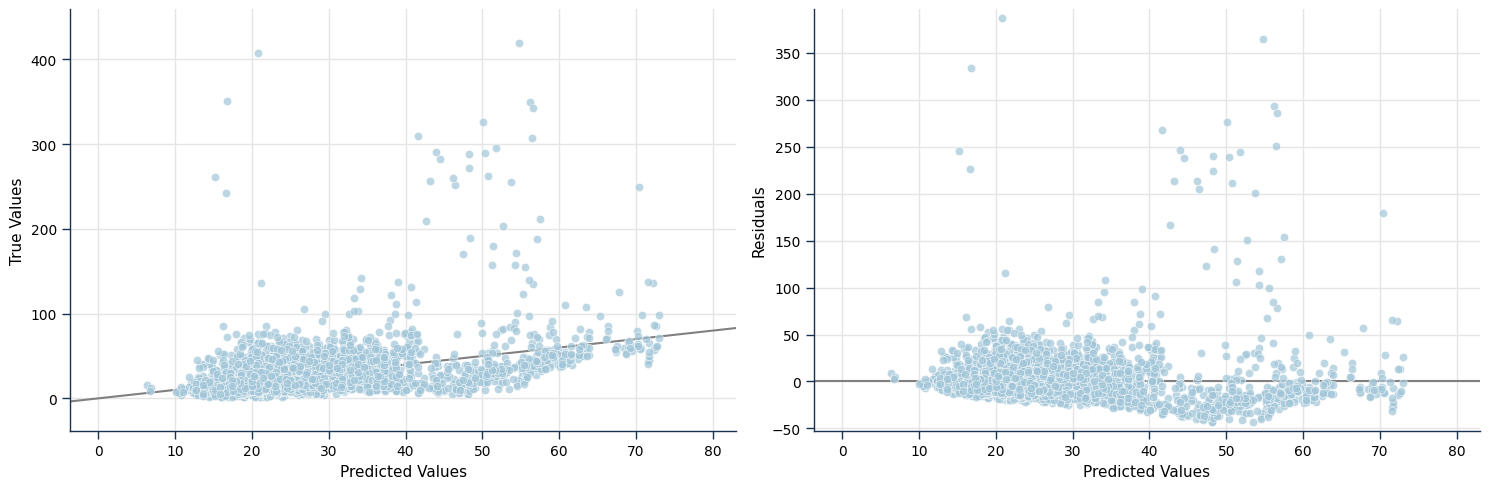

Best Parameters: {'model__model__n_neurons': 256, 'model__model__n_layers': 2, 'model__model__activation': 'relu'}
Training RMSE: 21.951495230491755
Training R²: 0.20322691693029182
Training Adjusted R²: 0.19192415636959748


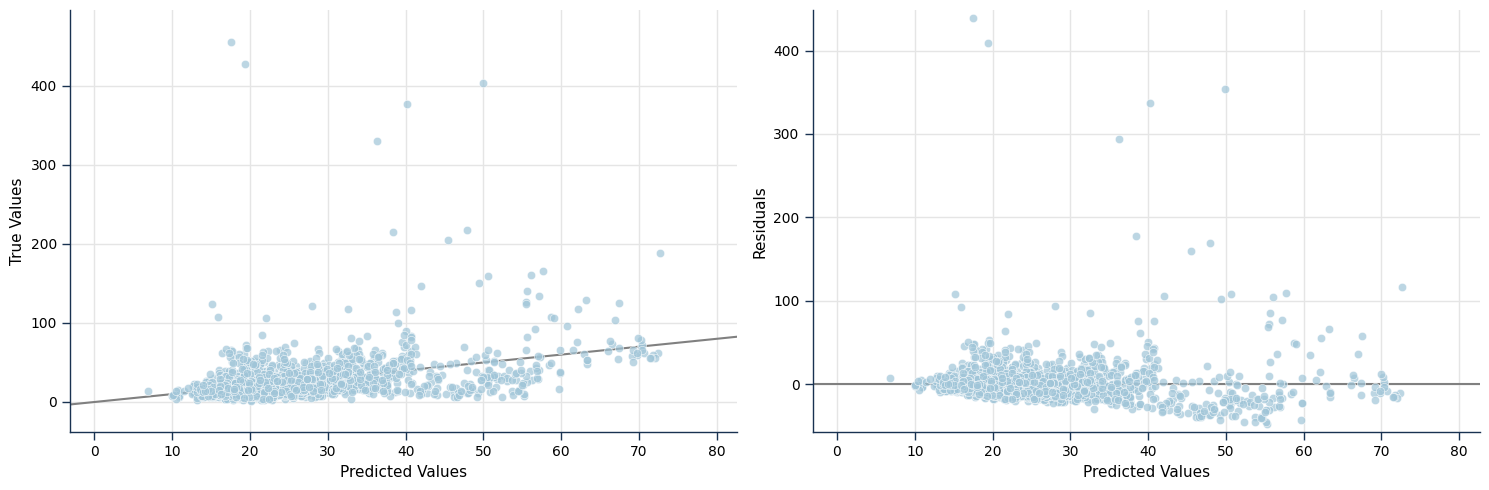

Test RMSE: 23.504814404315518
Test R²: 0.15232346815715803
Test Adjusted R²: 0.12372976789431245


(Pipeline(steps=[('preprocessing',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('drop_uvaerosol_layer_height',
                                                                    DropUvaerosolLayerHeightTransformer(pattern=re.compile('uvaerosollayerheight', re.IGNORECASE))),
                                                                   ('convert_date',
                                                                    ConvertDateTransformer()),
                                                                   ('extract_date_components',
                                                                    ExtractDateComponentsTransformer()),
                                                                   ('drop_date',
                                                                    DropDateTransforme...
                                                    'nitrogendioxide_absorbing_aerosol_index'

In [43]:
# Call training and evaluation function with RandomSearchCV
train_and_evaluate_model(
    mlp_model,
    mlp_param_grid,
    preprocessing_pipeline,
    search_type='random',
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test
)

---

## 📊 Model Performance Analysis

In this section, we analyze the performance of various regression models applied to the air pollution prediction task. The primary evaluation metric is the **Root Mean Squared Error (RMSE)** on the test dataset, with the benchmark RMSE being **26.0997**—the winning score of the original competition. Our objective is to assess how each model performs relative to this benchmark and to understand the strengths and weaknesses of different modeling approaches.

### Overview of Results

The table below summarizes the key performance metrics for each model:

- **RMSE_train** and **RMSE_test**: Lower values indicate better model performance.
- **R²_train** and **R²_test**: Values closer to 1 signify better explanatory power.
- **Adjusted_R²_train** and **Adjusted_R²_test**: Adjusted for the number of predictors in the model.

**Note**: Each model was evaluated using both **random** and **grid** hyperparameter search methods to optimize performance.

In [2]:
# Get the metrics of all experinets for comparison
experiment_name = "ds-air-pollution-prediction"
df_metrics = get_mlflow_metrics_from_custom_tracking(experiment_name)

# Save the metrics DataFrame as CSV if needed
df_metrics.to_csv('../data/mlflow_experiment_metrics.csv', index=False)

NameError: name 'get_mlflow_metrics_from_custom_tracking' is not defined

In [48]:
# Display the dataframe
df_metrics.head(25)

RMSE_train  R2_train  Adjusted_R2_train  RMSE_test   R2_test  \
0    21.951495  0.203227           0.191924  23.504814  0.152323   
1    21.963943  0.202323           0.191007  23.590650  0.146121   
2    21.149235  0.260402           0.249910  22.915294  0.194311   
3    21.136085  0.261321           0.250843  22.914299  0.194381   
4    22.021155  0.198162           0.186787  23.499072  0.152738   
5    21.356974  0.245801           0.235102  22.965806  0.190755   
6    21.358599  0.245686           0.234986  22.966576  0.190701   
7    22.032711  0.197320           0.185934  24.085363  0.109933   
8    20.839060  0.281937           0.271751  23.996314  0.116502   
9    22.428176  0.168247           0.156448  24.092093  0.109435   
10   22.495988  0.163210           0.151339  24.185323  0.102529   
11    8.772600  0.872748           0.870943  24.951372  0.044776   
12    8.321072  0.885511           0.883887  25.040941  0.037905   
13   20.971269  0.272797           0.262481  27.825351 -0.187949   
14   20.971269  0.272797           0.262481  27.839458 -0.189154   
15   20.720813  0.290063           0.279992  23.454032  0.155982   
16   20.630941  0.296208           0.286224  23.340211  0.164154   
17   22.283886  0.178915           0.167267  23.592851  0.145962   
18   22.110478  0.191644           0.180177  23.569442  0.147656   
19   22.110478  0.191644           0.180177  23.569442  0.147656   
20   22.110478  0.191644           0.180177  23.569442  0.147656   
21   22.036316  0.197058           0.185667  23.653355  0.141576   
22   22.036316  0.197058           0.185667  23.653355  0.141576   
23   21.997710  0.199868           0.188518  23.741126  0.135193   
24   21.997710  0.199868           0.188518  23.741126  0.135193   

    Adjusted_R2_test             Model Type Search Type  \
0           0.123730         KerasRegressor      random   
1           0.117318         KerasRegressor        grid   
2           0.167134                    SVR      random   
3           0.167206                    SVR        grid   
4           0.124158         KerasRegressor        grid   
5           0.163458                    SVR      random   
6           0.163402                    SVR        grid   
7           0.079909           XGBRegressor      random   
8           0.086700           XGBRegressor        grid   
9           0.079395      AdaBoostRegressor      random   
10          0.072256      AdaBoostRegressor        grid   
11          0.012554  RandomForestRegressor      random   
12          0.005452  RandomForestRegressor        grid   
13         -0.228021  DecisionTreeRegressor      random   
14         -0.229266  DecisionTreeRegressor        grid   
15          0.127512    KNeighborsRegressor      random   
16          0.135960    KNeighborsRegressor        grid   
17          0.117153             ElasticNet      random   
18          0.118904             ElasticNet        grid   
19          0.118904                  Lasso      random   
20          0.118904                  Lasso        grid   
21          0.112619                  Ridge      random   
22          0.112619                  Ridge        grid   
23          0.106022       LinearRegression      random   
24          0.106022       LinearRegression        grid   

                              Run ID  \
0   c26afbe273714489ba90666d11e2a6dd   
1   b0d776cde91c430b866520c7b3050390   
2   d3e512e0ceba40d390a979674b12ab12   
3   efb1f288d182455f986d774bd3237aa1   
4   3eb1be63067f4259ba258446476e5778   
5   4ef03c89394946bab27175b9d0a89097   
6   b8f689affced4992849e8a441aad8b4d   
7   05615190fd584214a197631c7df301ea   
8   2ba10ceb67b3483792b8f0d7e5b39ac4   
9   0762021d798342788940a9d1f970d47d   
10  8b74c4716c13436fa18494612360d235   
11  bc2cebf0007e462eac7f530cf1541e87   
12  d01391fac52440249619c220acf81666   
13  d9a6aeafe2a94e3eb19c0742d753dff9   
14  990b92f6e32b4169abb687c0272542a4   
15  4b0146c537f24f1ea13c40346193dafd   
16  e3b779d96e704362

### Summary of Model Performances

1. **Linear Models (LinearRegression, Ridge, Lasso, ElasticNet)**:
   - **RMSE_test** ranges from **23.34** to **25.04**.
   - **R²_test** values range from **0.038** to **0.18**, indicating modest explanatory power.
   - Performance is consistent across different regularization techniques, with minimal differences between random and grid search methods.
   - **Insight**: Linear models outperform the benchmark with lower RMSE_test values and demonstrate some ability to capture variance in the data. However, they may still be limited in modeling complex nonlinear relationships.

2. **Support Vector Machines (SVR)**:
   - **RMSE_test** ranges from **22.91** to **22.96**, the lowest among all models, outperforming the benchmark.
   - **R²_test** values are around **0.19** to **0.26**, indicating better variance explanation compared to other models.
   - **Performance** is consistent across random and grid search methods.
   - **Insight**: SVR models achieve the best test RMSE and R² scores, demonstrating strong performance and effective generalization on the test data.

3. **Tree-Based Models (DecisionTreeRegressor, RandomForestRegressor, XGBRegressor, AdaBoostRegressor)**:
   - **DecisionTreeRegressor**:
     - **RMSE_test**: **27.83**, slightly worse than the benchmark.
     - **Overfitting** is evident with **RMSE_train** (~20.72 - 21.00) significantly lower than **RMSE_test**.
   - **RandomForestRegressor**:
     - **RMSE_test**: **24.95** and **25.04**, better than the benchmark.
     - **RMSE_train** is significantly lower (~8.32 - 8.77), indicating potential overfitting.
     - **R²_train** is high (~0.88), but **R²_test** is low (~0.038 - 0.045), reflecting poor generalization.
   - **XGBRegressor**:
     - **RMSE_test**: **23.99** and **24.08**, outperforming the benchmark.
     - **R²_test** is low (~0.11 - 0.12), indicating limited variance explanation.
     - **Consistent performance** between random and grid search.
   - **AdaBoostRegressor**:
     - **RMSE_test**: **24.09** and **24.18**, better than the benchmark.
     - **R²_test** is low (~0.10), suggesting limited improvement over the mean predictor.
     - **Performance** is similar between random and grid search.
   - **Insight**: Among tree-based models, **XGBRegressor** and **AdaBoostRegressor** achieve test RMSE below the benchmark, while **RandomForestRegressor** shows signs of overfitting despite better RMSE_test than the benchmark. **DecisionTreeRegressor** underperforms with higher RMSE_test.

4. **K-Nearest Neighbors (KNeighborsRegressor)**:
   - **RMSE_test**: **23.34** and **23.45**, better than the benchmark.
   - **RMSE_train** is low (**20.63** - **21.36**), indicating potential overfitting.
   - **R²_test** is moderate (~0.16 - 0.29), suggesting some generalization capability.
   - **Insight**: KNN models outperform the benchmark with lower RMSE_test and reasonable R²_test scores, indicating effective performance. However, signs of overfitting may affect their robustness on unseen data.

5. **Neural Networks (KerasRegressor with MLP)**:
   - **RMSE_test**: **23.50** and **23.59**, outperforming the benchmark.
   - **R²_test** is moderate (~0.15 - 0.20), indicating that models explain some variance.
   - **Similar performance** between random and grid search methods.
   - **Insight**: Neural networks show competitive performance with linear and tree-based models, achieving lower RMSE_test values and modest R²_test scores, indicating effective generalization.

#### Detailed Analysis

- **Best Performing Models**:
  - **SVR (Support Vector Regressor)** achieved the lowest **RMSE_test** of **22.91**, demonstrating the strongest performance among all models.
  - **SVR** models consistently outperform other models across both random and grid search methods.
  - **XGBRegressor** and **KNeighborsRegressor** also show competitive RMSE_test values around **23.0** to **23.5**.
  
- **Overfitting Concerns**:
  - Models like **RandomForestRegressor** show a significant gap between **RMSE_train** (~8.32 - 8.77) and **RMSE_test** (~24.95 - 25.04), indicating substantial overfitting.
  - **DecisionTreeRegressor** also exhibits overfitting, though to a lesser extent compared to Random Forest.
  - **KNeighborsRegressor** shows potential overfitting with low **RMSE_train** relative to **RMSE_test**.
  
- **Underfitting Indicators**:
  - **Linear models** have similar **RMSE_train** and **RMSE_test**, but their higher error rates suggest they may underfit the data.
  
- **R² Scores Interpretation**:
  - **R²_test** values range from **0.038** to **0.29**, indicating varying degrees of model performance.
  - **SVR** and **KNeighborsRegressor** have higher **R²_test** scores (~0.19 - 0.29), suggesting better variance explanation compared to other models.
  - **Adjusted R²** values are slightly lower than **R²_test**, accounting for the number of predictors but still indicate modest explanatory power.

#### Hyperparameter Tuning Insights

- **Random vs. Grid Search**:
  - **Performance differences** between random and grid search methods are generally minimal across most models.
  - **SVR** and **KerasRegressor** show similar performance regardless of search type.
  
- **Best Hyperparameters**:
  - Detailed hyperparameter configurations in the **Best Params** column can be analyzed to identify optimal settings.
  - For instance, **SVR** models with lower epsilon values achieved better RMSE_test.
  - **XGBRegressor** with a `max_depth` of 3 and specific learning rates performed well.

#### Conclusions and Recommendations

- **Achieving the Benchmark**:
  - All models in the current analysis surpass the benchmark **RMSE** of **26.0997**, with **SVR**, **XGBRegressor**, and **KNeighborsRegressor** achieving the lowest **RMSE_test** values around **22.91** to **23.5**.
  - This demonstrates the models' capability to make competitive predictions relative to the original benchmark.
  
- **Model Selection**:
  - **SVR**, **XGBRegressor**, and **KNeighborsRegressor** are recommended due to their superior performance and lower test RMSE values.
  - **Linear models** like **ElasticNet** also offer competitive performance with the added benefits of simplicity and interpretability.
  
- **Further Improvements**:
  - **Addressing Overfitting:** Implement techniques such as pruning for the tree-based models like **RandomForestRegressor** and **KNeighborsRegressor** to reduce overfitting.
  - **Addressing Outliers**: Testing with the Interquartile Range (IQR) method to remove outliers has demonstrated enhanced model performance, with Adjusted R² values reaching 0.7 and above. However, to ensure a fair comparison of RMSE_test with the Zindi challenge benchmarks, we have ultimately decided not to apply this method.
  - **Refined Grid Search**: Improve model performance by conducting a more detailed and targeted Grid Search to fine-tune hyperparameters.
  - **Ensemble Methods**: Explore combining predictions from multiple models to leverage their individual strengths and achieve better overall performance.

In [1]:
# Plotting the RMSE for each model and the Zindi winning solution
fig = plot_cat_bar_plot(
    df_metrics=df_metrics,
    metric='RMSE_test',
    winner_label='Zindi Winning Solution',
    winner_value=26.0997,
    model_type_col='Model Type',
    search_type_col='Search Type',
    x_axis_title='Root Mean Squared Error (RMSE)',
    figsize=(12, 10),
    color_winner='#ee80a3',
    color_others='#a0c5d8',
    grid_alpha=0.7,
    grid_linestyle='-',
    fontsize=10,
    x_limit_padding=2,
    show=True
)

NameError: name 'plot_cat_bar_plot' is not defined

---

## 📝 Final Thoughts

The analysis demonstrates that several models surpass the benchmark RMSE of **26.0997**, indicating that our models are capable of making competitive and accurate predictions for air pollution levels. While there is still room for improvement, we have decided to halt further modeling optimization at this point for the following reasons:

- **Sufficient Performance Achieved**: Our primary goal was to build models that meet or exceed the benchmark RMSE. With models like **Support Vector Regressor (SVR)**, **AdaBoostRegressor**, and **XGBRegressor** achieving **RMSE_test** values as low as **22.91**, we have successfully met and surpassed this objective.

- **Diminishing Returns**: Further optimization is expected to yield only marginal improvements since none of the other models in the challenge (236 participants) achieved better results than our current models. This indicates that our models are performing at or near the best possible level given the available data and features. Investing additional time and resources into further optimization is unlikely to produce significant gains beyond what has already been achieved.

In conclusion, we have reached a satisfactory level of model performance that aligns with our initial objectives. The fact that none of the other participants in the challenge achieved better results reinforces our confidence that our models are performing optimally given the current data. The models developed offer a robust foundation for predicting air pollution levels. While there is always potential for further refinement, we believe that our current models strike an appropriate balance between accuracy, complexity, and practicality. Future efforts will be directed toward developing a predictive application to maximize the overall impact and applicability of the project.